In [1]:
import numpy as np
import scipy as sp
from scipy import interpolate
import pandas as pd
import glob
from IPython.display import clear_output
import random
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import style
style.use('seaborn-darkgrid')

In [4]:
filenames = ['ZAMS_new/aic_10colA', 'ZAMS_new/aic_10colB']
data = np.concatenate([np.loadtxt(f) for f in filenames])
len(data)

93928

In [48]:
def read_evo_history(EvoHist, zipped):
    ehists = []
    for i in range( len(EvoHist) ):
        if os.stat(EvoHist[i]).st_size != 0:
            if zipped == True:
                try:   
                    ehists.append( pd.read_csv(EvoHist[i], delimiter = "\t", compression='gzip', header=None).to_numpy() )
                except pd.errors.EmptyDataError:
                    pass
            else:
                try:   
                    ehists.append( pd.read_csv(EvoHist[i], delimiter = "\t", header=None).apply(pd.to_numeric, errors='coerce').to_numpy() )
                except ValueError:
                    pass

    return ehists

foldername = "OutputFiles_test_v1"

EvoHist = glob.glob("./"+foldername+"/EvoHist*.gz")
ehists = read_evo_history(EvoHist, True)

# EvoHist = glob.glob("./"+foldername+"/EvoHist*.dat")
# ehists = read_evo_history(EvoHist, False)

print(np.shape(ehists))

(664,)


#### Save NB variables?

In [6]:
# dill.dump_session(foldername+'_env.db')
# dill.load_session(foldername+'_env.db')

In [7]:
np.seterr(divide = 'ignore') ;
np.seterr(invalid = 'ignore') ;

## Rough

In [8]:
def plot_it(n):
    data = ehists[n]
    Rsun = 695700  ##km
    Msun = 1.989e30  ##kg

    k_acc = []
    k_donor = []
    aic = False
    onewd = False
    j=0
    for j in range(1, np.shape(data)[0] ):
        if data[j,5] != data[j-1,5]:
            k_acc.append( [data[j,5], data[j-1,5], data[j,1], data[j,3], data[j,4]] )
        if data[j,9] != data[j-1,9]:
            k_donor.append( [data[j,9], data[j-1,9], data[j,1], data[j,7], data[j,8]] )    
        
        if data[j,5] == 12:
            onewd = True
        if data[j,5] == 13 and onewd == True:
            aic = True
        elif data[j,5] == 13 and onewd == False:
            aic = False
        if data[j,5] == 13:
            t_coll = data[j,1]*1e6
            a = data[j,2]
            r = data[j,4]
            r_donor = data[j,8]
            m_acc = data[j,3]
            m_donor = data[j,7]
            k_acc = np.array(k_acc)
            k_donor = np.array(k_donor)
            break
    if data[j,5] == 13:
        fig = plt.figure(figsize=(18,20))
        fig.tight_layout()
        
        ax1 = fig.add_subplot(3,2,1)
        ax1.plot(data[:,1], np.log10(data[:,3]*Msun),  c="0.4", label=r"$M_{prim}$")
#         plt.scatter(t_coll/1e9, np.log10(m_acc*Msun), c="0.4")
        for i in range(len(k_acc)):
            ax1.scatter(k_acc[i,2], np.log10(k_acc[i,3]*Msun), label="k : %i --> %i" %(k_acc[i,1], k_acc[i,0]))
        plt.xlabel("Time in Myrs")
        plt.ylabel(r"$\log(\frac{M_{prim}}{kg} ) $")
        plt.title("Mass evolution of the Primary")
        plt.legend()
        plt.xlim(0,140)
        
        ax2 = fig.add_subplot(3,2,2)
        ax2.plot(data[:,1], np.log10(data[:,7]*Msun), c="palevioletred", label=r"$M_{sec}$")
#         plt.scatter(t_coll/1e9, np.log10(m_donor*Msun), c="palevioletred")
        for i in range(len(k_donor)):
            ax2.scatter(k_donor[i,2], np.log10(k_donor[i,3]*Msun), label="k : %i --> %i" %(k_donor[i,1], k_donor[i,0]))
        plt.xlabel("Time in Myrs")
        plt.ylabel(r"$\log(\frac{M_{sec}}{kg} ) $")
        plt.title("Mass evolution of the Secondary")
        plt.legend()
        plt.xlim(0,140)
        
        ax3 = fig.add_subplot(3,2,3)
        ax3.plot(data[:,1], np.log10(data[:,4]*Rsun), c="0.4")
#         plt.scatter(t_coll/1e9, np.log10(r*Rsun), c="0.4", label="AIC event")
        for i in range(len(k_acc)):
            ax3.scatter(k_acc[i,2], np.log10(k_acc[i,4]*Rsun), label="k : %i --> %i" %(k_acc[i,1], k_acc[i,0]))
        plt.xlabel("Time in Myrs")
        plt.ylabel(r"$\log( \frac{R_{prim}}{km} ) $")
        plt.title("Radius evolution of the Primary")
        plt.legend()
        plt.xlim(0,140)
        
        ax4 = fig.add_subplot(3,2,4)
        ax4.plot(data[:,1], np.log10(data[:,8]*Rsun), c="palevioletred")
#         plt.scatter(t_coll/1e9, np.log10(r_donor*Rsun), c="palevioletred", label="AIC event")
        for i in range(len(k_donor)):
            ax4.scatter(k_donor[i,2], np.log10(k_donor[i,4]*Rsun), label="k : %i --> %i" %(k_donor[i,1], k_donor[i,0]))
        plt.xlabel("Time in Myrs")
        plt.ylabel(r"$\log( \frac{R_{second}}{km} ) $")
        plt.title("Radius evolution of the Secondary")
        plt.legend()
        plt.xlim(0,140)
        
        ax5 = fig.add_subplot(3,1,3)
        ax5.plot(data[:,1], np.log10(data[:,2]), c="orange")
        ax5.scatter(t_coll/1e6, np.log10(a), c="palevioletred", label="AIC event")
        plt.xlabel("Time in Myrs")
        plt.ylabel(r"$\log( \frac{a}{R_\odot} ) $")
        plt.title("Orbital separation evolution")
        plt.legend()
        plt.xlim(0,140)
#         plt.savefig("heaccr_aic")
        plt.show()
        
    return aic

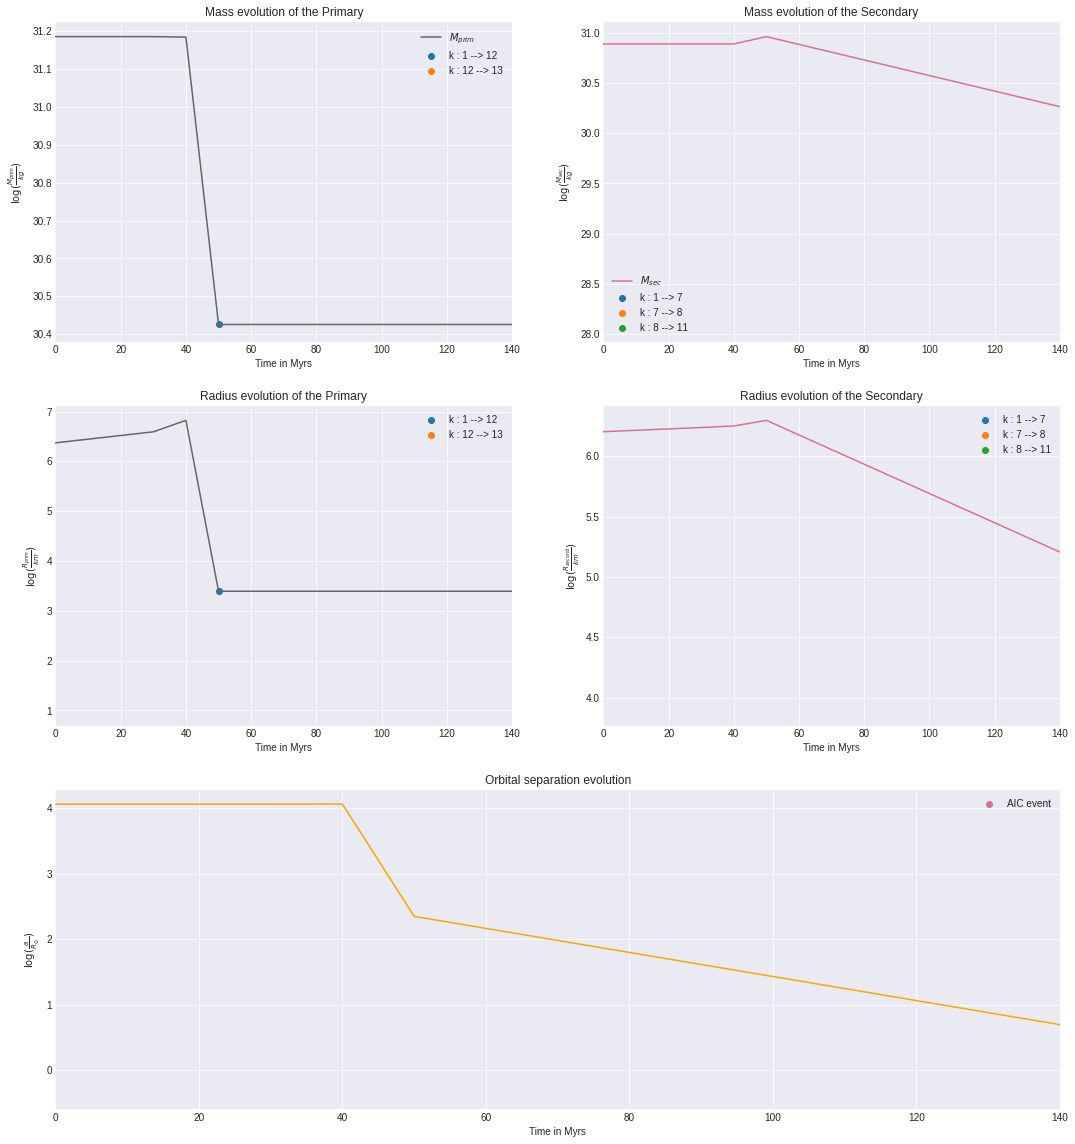

3 True


In [10]:
s = 0
# s = i+1
# s = i
for i in range(s, len(ehists)):
    aic = plot_it(i)
    if aic == True:
        print(i, aic)
        break

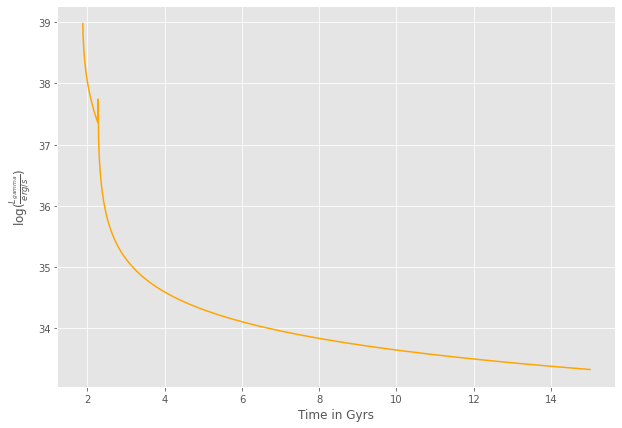

In [345]:
data = ehists[maxi]
plt.figure(figsize=(10, 7))
plt.plot(data[:,0]/1e3, np.log10(data[:,15]*f_bulge), c="orange")
plt.xlabel("Time in Gyrs")
plt.ylabel(r"$\log( \frac{L_{gamma}}{erg/s} ) $")
plt.show()

In [25]:
t = np.arange(0, t_end, 1e9)
P_orb = [[]]*(len(t))
M2 = [[]]*(len(t))
k2 = [[]]*(len(t))
G = 2942 ###R_☉^3/(M_☉ day^2) (solar radii cubed per solar mass day squared)


for i in range( len(ehists) ):
    aic = False
    onewd = False
    for j in range( np.shape(ehists[i])[0] ):
        if ehists[i][j,5] == 12:
            onewd = True
        if ehists[i][j,5] == 13 and onewd == True:
            aic = True
            
            if aic == True and ehists[i][j,5] == 13 and ehists[i][j,12] <= 10e-3:
                if int(ehists[i][j,0]/1e3)!=int(ehists[i][j-1,0]/1e3):
                    m1 = ehists[i][j,3]
                    m2 = ehists[i][j,7]
                    a = ehists[i][j,2]
                    p = 2*np.pi* np.sqrt(a**3 / G*(m1+m2))
                    P_orb[ int(ehists[i][j,0]/1e3) ].append(p)
                    M2[ int(ehists[i][j,0]/1e3) ].append(m2)
                    k2[ int(ehists[i][j,0]/1e3) ].append( ehists[i][j,9] )
            
        elif ehists[i][j,5] == 13 and onewd == False:
            aic = False
            break


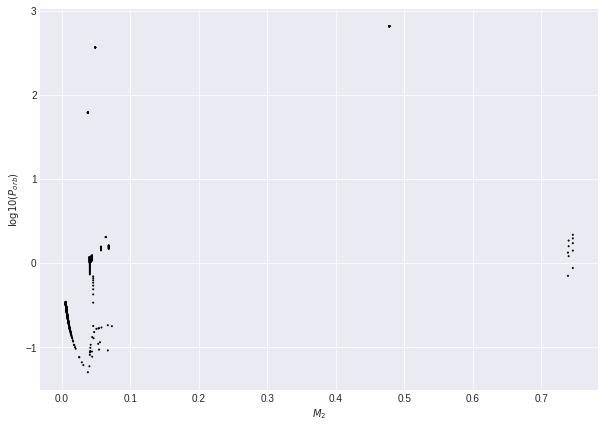

In [28]:
time = 14
plt.figure(figsize=(10, 7))
# plt.scatter(M2[time], np.log10(P_orb[time]), s=1, c='r')
plt.scatter(M2[time], np.log10(P_orb[time]), s=1, c=np.array(k2[time]))
plt.xlabel(r"$M_2$")
plt.ylabel(r"$\log10(P_{orb})$")
plt.show()

In [15]:
len(M2[4])

54

## MWB SFR

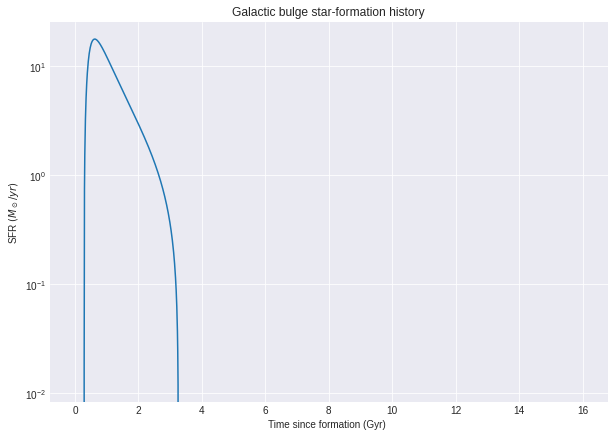

In [49]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx



def f(z):
    A = -2.62e-2
    B = 0.384
    C = -8.42e-2
    return A*z**2 + B*z + C 
D = 3.254

def z(t):
    t0 = 15e9
    k = t0**(2/3)     # today at z = 0, t = t0
    if t == 0:
        z = 1e10
    else:
        z = k*(t)**(-2/3) - 1
    return z
    
dt = 1e7
t_end = 16e9

t = np.arange(0, t_end, dt)
sfr = []
for time in t:  
    rate = 10**(max(f(z(time)), 0)) - D
    if rate > 0:
        sfr.append(rate)
    else:
        sfr.append(0)


sfh = np.array(sfr)
# sfr = (sfh*dt/M_bulge)
sfr = sfh

# sfr = (sfh*dt/M_sim) / sum(sfh*dt/M_sim)

plt.figure(figsize = (10,7))
plt.semilogy(t/1e9, sfr)
plt.ylabel('SFR $(M_\odot/yr)$')
plt.xlabel('Time since formation (Gyr) ')
plt.title('Galactic bulge star-formation history')
plt.show()

## $\gamma$-ray & X-ray calculations

In [50]:
t = np.arange(0, t_end, dt)
L_int = np.zeros( int(t_end/dt) )
count_msp = np.zeros( int(t_end/dt) )
L_g_noaic = np.zeros( int(t_end/dt) )
count_msp_noaic = np.zeros( int(t_end/dt) )
L_x = np.zeros( int(t_end/dt) )
count_x = np.zeros( int(t_end/dt) )
L_x_wd = np.zeros( int(t_end/dt) )
L_x_ns = np.zeros( int(t_end/dt) )

G = 1.3218607e+26               # km**3 * MSun**(-1) * yr**(-2)
c = 9.4605284e12                # km/yr
RSun = 695700   ## km

for i in range( len(ehists) ):
    aic = False
    onewd = False
    if len(ehists[i]) != 18:
        for j in range( np.shape(ehists[i])[0] ):
            if ehists[i][j,5] == 12:
                onewd = True
                
            if ehists[i][j,5] == 13 and onewd == True:
                aic = True
                if int(ehists[i][j,0]*1e6/dt) != int(ehists[i][j-1,0]*1e6/dt):
                    w_breakup = np.sqrt(G*ehists[i][j,3]/(ehists[i][j,4]*RSun)**3)
                    P_breakup = ( 2 * np.pi /(w_breakup) ) * 3.154e+7    #seconds
                    ## Gamma-ray # AIC NS
                    if ehists[i][j,5] == 13 and P_breakup<ehists[i][j,12]<100e-3 and ehists[i][j,15] > 0 and aic == True:
                        count_msp[ int(ehists[i][j,0]*1e6/dt) ] += 1
                        f, alpha, beta = 0.0122, -2.12, 0.82                                    ##slot-gap two-pole caustic (TPC) Gonthier 2018
                        # L_gamma = 2.7621525e22 * f * (P/1e-3)**alpha * (P_dot/1e-21)**beta            ## erg/s
                        L_gamma = 6.8172e35 * f * (ehists[i][j,12]/1e-3)**alpha * (ehists[i][j,13]/1e-20)**beta            ## eV/s
                        L_int[ int(ehists[i][j,0]*1e6/dt) ] +=  L_gamma
#                         L_int[ int(ehists[i][j,0]*1e6/dt) ] += ehists[i][j,15]

                    if ehists[i][j,5] == 13 and ehists[i][j,12]<P_breakup and ehists[i][j,15] > 0 and aic == True:
                        count_msp[ int(ehists[i][j,0]*1e6/dt) ] += 1
                        f, alpha, beta = 0.0122, -2.12, 0.82                                    ##slot-gap two-pole caustic (TPC) Gonthier 2018
                        # L_gamma = 2.7621525e22 * f * (P/1e-3)**alpha * (P_dot/1e-21)**beta            ## erg/s
                        L_gamma = 6.8172e35 * f * (P_breakup/1e-3)**alpha * (ehists[i][j,13]/1e-20)**beta            ## eV/s
                        L_int[ int(ehists[i][j,0]*1e6/dt) ] +=  L_gamma
                        
                                                    
            elif ehists[i][j,5] == 13 and onewd == False:
                aic = False
                if int(ehists[i][j,0]*1e6/dt) != int(ehists[i][j-1,0]*1e6/dt):
                    ## Gamma-ray # non-AIC NS
                    if ehists[i][j,5] == 13 and ehists[i][j,12]<100e-3 and aic == False:
                        count_msp_noaic[ int(ehists[i][j,0]*1e6/dt) ] += 1
                        L_g_noaic[ int(ehists[i][j,0]*1e6/dt) ] += ehists[i][j,15]
                                                    
            ## X-ray
            if int(ehists[i][j,0]*1e6/dt) != int(ehists[i][j-1,0]*1e6/dt):
                if (ehists[i][j,5] == 13 or ehists[i][j,5] in [10,11,12]) and abs(ehists[i][j,6])>0:  ## if primary is an accreting WD or NS
    #                 L_x[ int(ehists[i][j,0]*1e6/dt) ] += np.abs(ehists[i][j,11])
                    if abs(ehists[i][j,6])>0:
                        eta = 0.1
                        L_xi = eta * G * ehists[i][j,3] * abs(ehists[i][j,6]) / (ehists[i][j,4]*695700)
                        L_xi = L_xi * 2e33 * (1e5)**2 / (3.154e+7)**3  # ergs/s

    #                     R_sch = 2 * G * ehists[i][j,3] / c**2
    #                     eta = R_sch / (ehists[i][j,4]*695700)
    #                     L_bol = eta * 0.5 * abs(ehists[i][j,6]) * c**2
    #                     L_xi = 0.1 * L_bol
    #                     L_xi = L_xi * 2e33 * (1e5)**2 / (3.154e+7)**3  # ergs/s
                    else:
                        L_xi = 0
                    L_x[ int(ehists[i][j,0]*1e6/dt) ] += L_xi
                    if L_xi>1e36:
                        count_x[ int(ehists[i][j,0]*1e6/dt) ] += 1
                    if (ehists[i][j,5] in [10,11,12] and ehists[i][j,6]>0) or (ehists[i][j,9] in [10,11,12] and ehists[i][j,10]>0):
                        L_x_wd[ int(ehists[i][j,0]*1e6/dt) ] += L_xi
                    if (ehists[i][j,5] == 13 and ehists[i][j,6]>0) or (ehists[i][j,9] == 13 and ehists[i][j,10]>0):
                        L_x_ns[ int(ehists[i][j,0]*1e6/dt) ] += L_xi
                    
count_msp_sim = np.array(count_msp)
L_int_sim = np.array(L_int)

count_x_sim = np.array(count_x)
L_x_int_sim = np.array(L_x)

L_x_wd_sim = np.array(L_x_wd)
L_x_ns_sim = np.array(L_x_ns)

In [51]:
M_bulge = 2e10
M_sim = 7.3e8
f_bulge = M_bulge/M_sim

In [52]:
count_msp = count_msp_sim * (f_bulge)
L_int = L_int_sim * (f_bulge)

count_x = count_x_sim * (f_bulge)
L_x_int = L_x_int_sim * (f_bulge)

L_x_wd = L_x_wd_sim * (f_bulge)
L_x_ns = L_x_ns_sim * (f_bulge)

AIC events

In [39]:
t = np.arange(0, t_end, dt)
aic_events = np.zeros( int(t_end/dt) )
other_channel = np.zeros( int(t_end/dt) )
k_donor = []
t_aic = []

for i in range( len(ehists) ):
    aic = False
    onewd = False
    for j in range( np.shape(ehists[i])[0] ):
        if int(ehists[i][j,0]*1e6/dt) != int(ehists[i][j-1,0]*1e6/dt) and ehists[i][j,2]> (ehists[i][j,4]+ehists[i][j,8]):
            if ehists[i][j,5] == 12:
                onewd = True
            if ehists[i][j,5] == 13 and onewd == True:
                aic = True
                aic_events[ int(ehists[i][j,0]*1e6/dt) ] += 1
                k_donor.append(ehists[i][j,9])
                t_aic.append(ehists[i][j,0])
                break
            elif ehists[i][j,5] == 13 and onewd == False:
                other_channel[ int(ehists[i][j,0]*1e6/dt) ] += 1
                aic = False
                break

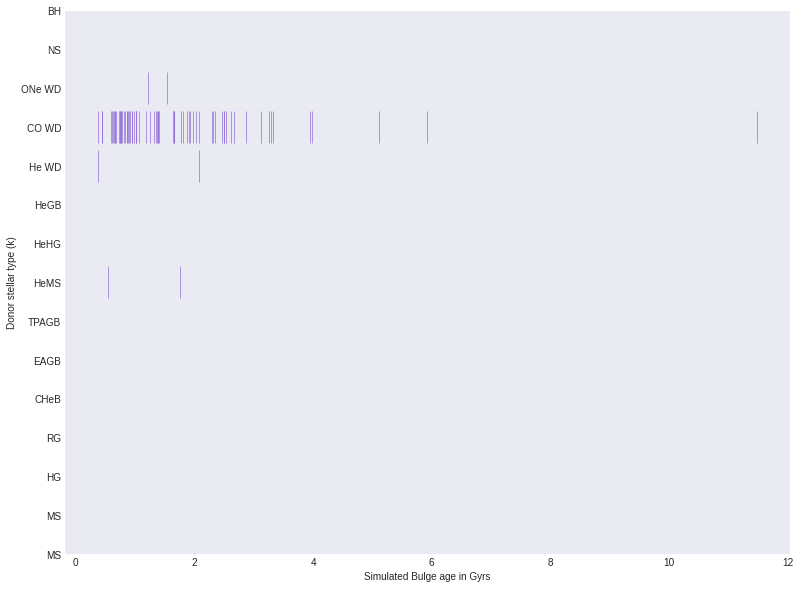

In [40]:
labels = [ "MS", "MS", "HG",  "RG", "CHeB", "EAGB", "TPAGB", "HeMS", "HeHG", "HeGB", "He WD", "CO WD", "ONe WD", "NS", "BH"] 
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(1,1,1)
fig.canvas.draw()
ax.scatter(np.array(t_aic)/1e3, k_donor, marker="|", c="mediumpurple", s=1000, linewidth=0.7)
plt.yticks(np.arange(0, 15, 1))
ax.grid(False)
ax.set_yticklabels(labels)
plt.xlabel(r"Simulated Bulge age in Gyrs")
plt.ylabel(r"Donor stellar type (k)")
plt.show()

In [41]:
max(other_channel)

1.0

### $\gamma$-ray plots

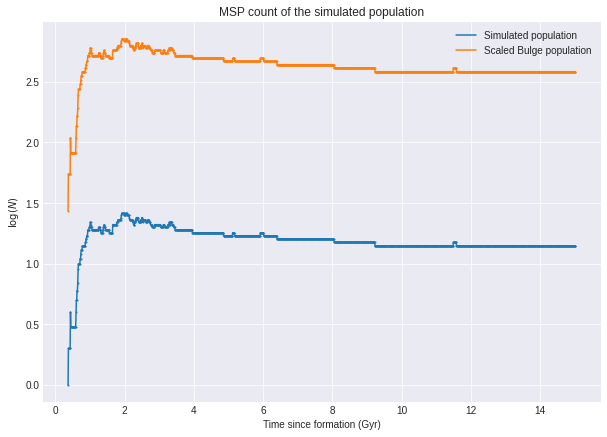

In [42]:
t = np.arange(0, t_end, dt)
plt.figure( figsize = (10,7) )
plt.scatter(t/1e9, np.log10(count_msp_sim), 1)
plt.plot(t/1e9, np.log10(count_msp_sim), label='Simulated population')
plt.scatter(t/1e9, np.log10(count_msp), 1)
plt.plot(t/1e9, np.log10(count_msp), label='Scaled Bulge population')
plt.ylabel('$\log (N)$')
plt.xlabel('Time since formation (Gyr)')
plt.title('MSP count of the simulated population')


# xdata = (t/1e9)
# ydata = count_msp
# y_fit = pd.Series(ydata).rolling(window=300, min_periods=0, center=True).mean()
# plt.plot(t/1e9, np.log10(y_fit), 'b-')
plt.legend()
plt.show()

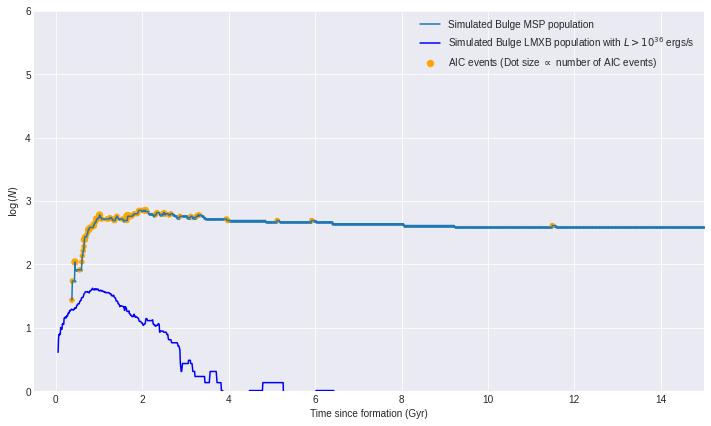

In [44]:
## gAmma-ray
t = np.arange(0, t_end, dt)
plt.figure( figsize = (12,7) )
plt.scatter(t/1e9, np.log10(count_msp), 1)
plt.plot(t/1e9, np.log10(count_msp), label=r'Simulated Bulge MSP population')
plt.ylabel('$\log (N)$')
plt.xlabel('Time since formation (Gyr)')

##X-ray
c = np.array(count_x).copy()
f = 1
count_x = [c[i] for i in range(len(c)) if i%f==0 ]
t = np.arange(0, t_end, dt*f)
xdata = (t/1e9)[5:]
ydata = count_x[5:]
y_fit = pd.Series(ydata).rolling(window=80, min_periods=0, center=True).mean()
plt.plot((t/1e9)[5:], np.log10(y_fit), 'b-', label=r'Simulated Bulge LMXB population with $L>10^{36}$ ergs/s')

t_aic = np.array([t[i] for i in range(len(t)) if aic_events[i]>0 ])
n_aic = np.array([aic_events[i] for i in range(len(t)) if aic_events[i]>0 ])
y_aic = np.array([count_msp[i] for i in range(len(t)) if aic_events[i]>0 ])
plt.scatter(t_aic/1e9, np.log10(y_aic), s=n_aic*20, c='orange', label=r'AIC events (Dot size $\propto$ number of AIC events)')
plt.legend()
plt.xlim(-0.5,15)
plt.ylim(0,6)
plt.savefig("BulgeLMXBandMSPpopulation")
plt.show()

count_x = c.copy()

IndexError: index 0 is out of bounds for axis 0 with size 0

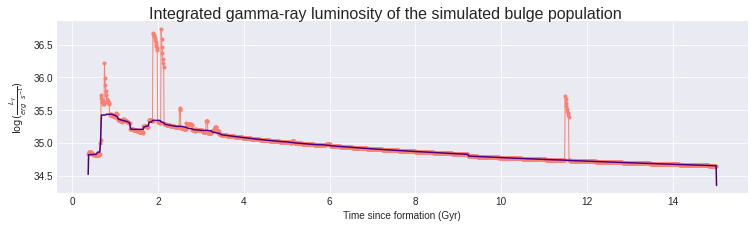

In [45]:
def newline(p1, p2, ax, c, label):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], c = c, alpha = 1, label = label, zorder=15)
    ax.add_line(l)
    return l

def add_sub_plot(Lg_obs, u, l, c, label, ax):
    # plt.scatter(t/1e9, np.log10(L_int), 1, zorder=5)
    ax.plot(t/1e9, np.log10(L_int), '-o', c="salmon", ms=3, linewidth = 1, label = r'Integrated $L_\gamma$ time series', zorder=5)
    plt.ylabel(r'$\log( \frac{L_{\gamma}}{erg\ \ s^{-1}})$')
    plt.xlabel('Time since formation (Gyr)')
#     plt.title('Integrated gamma-ray luminosity of the simulated bulge population')

    xdata = (t/1e9)
    ydata = L_int
    y_fit = pd.Series(ydata).rolling(window=50, min_periods=0, center=True).median()
    ax.plot(t/1e9, np.log10(y_fit), c='indigo', label = r'Integrated $L_\gamma$ moving median', zorder=10)
    L_gint = y_fit
    t_agree_gamma = interpolate.InterpolatedUnivariateSpline(t/1e9, y_fit-Lg_obs).roots()[0:]
    y_new = [np.log10(Lg_obs)]*len(t_agree_gamma)
    err = np.array([[np.log10(Lg_obs)-l, u-np.log10(Lg_obs)]]*len(t_agree_gamma)).T
    line = newline( [t_agree_gamma[0], y_new[0]], [t_agree_gamma[-1], y_new[-1]], ax,
                c=c, label=label)
    ax.fill_between(line.get_data()[0], l, u, alpha = 0.3, edgecolor=c, facecolor=c, linewidth=1,
                     label = label, zorder=1)
    plt.xlim(0,15)
    plt.ylim(34,40)

#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys())
    
    return L_gint
    

    

t = np.arange(0, t_end, dt)
fig = plt.figure(figsize=(12,10), constrained_layout=False)
plt.suptitle('Integrated gamma-ray luminosity of the simulated bulge population', x=0.43, y=0.98, fontsize=16)

gs1 = fig.add_gridspec(nrows=3, ncols=3, top=0.96, left = 0.05, right = 0.85, bottom = 0.1,
                        wspace=0.05, hspace=0.3)

ax1 = fig.add_subplot(gs1[0,:])
Lg_obs = 1.3e37     ## erg/s     ###eckner
u = np.log10(Lg_obs + 0.9e37)
l = np.log10(Lg_obs - 1.1e37)
L_gint = add_sub_plot(Lg_obs, u, l, "chocolate", r"MW Bulge observed $L_\gamma$ (Eckner et al., 2018)", ax1)

gs2 = fig.add_gridspec(nrows=3, ncols=2, top=0.89, left = 0.05, right = 0.85, bottom = 0.1,
                        wspace=0.2, hspace=0.3)

ax2 = fig.add_subplot(gs2[1,0])
Lg_obs = 1.85e37     ## erg/s     ###Ploeg et al. (2017) spherical Bulge
u = np.log10(Lg_obs + 1.29e37)
l = np.log10(Lg_obs - 1.29e37)
L_gint = add_sub_plot(Lg_obs, u, l, "maroon", r"Ploeg et al. (2017) (Spherical Bulge)", ax2)


ax3 = fig.add_subplot(gs2[1,1])
Lg_obs = 3e37     ## erg/s     ###Ploeg et al. (2017) (X-shaped MW bulge)
u = np.log10(Lg_obs + 1.6e37)
l = np.log10(Lg_obs - 1.6e37)
L_gint = add_sub_plot(Lg_obs, u, l, "blue", r"Ploeg et al. (2017) (X-shaped MW Bulge)", ax3)

ax4 = fig.add_subplot(gs2[2,0])
Lg_obs = 2.8e37     ## erg/s     ###Bartels et al. (2017)
u = np.log10(Lg_obs + 1.27e37)
l = np.log10(Lg_obs - 1.27e37)
L_gint = add_sub_plot(Lg_obs, u, l, "olive", r"Bartels et al. (2017)", ax4)

ax5 = fig.add_subplot(gs2[2,1])
Lg_obs = 1.7e37     ## erg/s     ###Winter et al. (2016)
u = np.log10(Lg_obs + 2.6e37)
l = np.log10(Lg_obs - 1e37)
L_gint = add_sub_plot(Lg_obs, u, l, "darkslategray", r"Winter et al. (2016)", ax5)



axes = [ax1,ax2,ax3,ax4,ax5]
handles, labels = [], []
for ax in axes[:5]:
    handles_, labels_ = ax.get_legend_handles_labels()
    handles += handles_
    labels += labels_
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), ncol=4, mode='expand', loc='upper center', bbox_to_anchor=(0.01, 0.15, 0.9, 0.52))
# fig.legend(by_label.values(), by_label.keys())

plt.savefig("L_gamma_comp.pdf")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

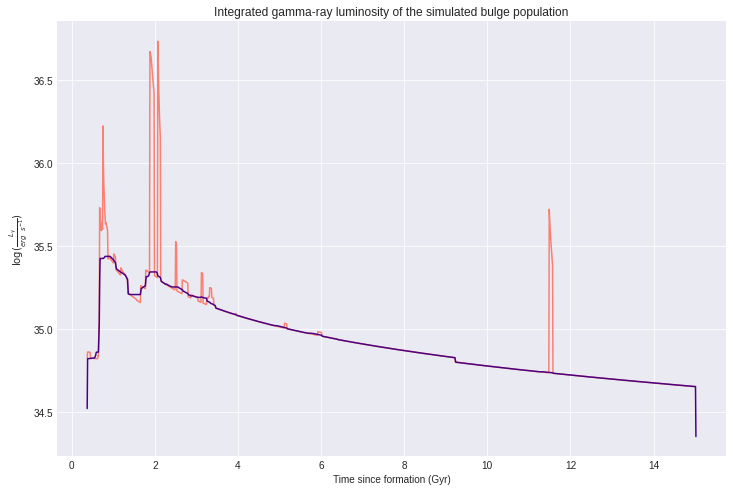

In [46]:
def newline(p1, p2, ax, c, label):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], c = c, alpha = 1, label = label, zorder=15)
    ax.add_line(l)
    return l

def add_sub_plot(Lg_obs, u, l, c, label, ax):
    # plt.scatter(t/1e9, np.log10(L_int), 1, zorder=5)
    ax.plot(t/1e9, np.log10(L_int), c="salmon", label = r'Integrated $L_\gamma$ time series', zorder=5)
    plt.ylabel(r'$\log( \frac{L_{\gamma}}{erg\ \ s^{-1}})$')
    plt.xlabel('Time since formation (Gyr)')
#     plt.title('Integrated gamma-ray luminosity of the simulated bulge population')

    xdata = (t/1e9)
    ydata = L_int
    y_fit = pd.Series(ydata).rolling(window=50, min_periods=0, center=True).median()
    ax.plot(t/1e9, np.log10(y_fit), c='indigo', label = r'Integrated $L_\gamma$ moving median', zorder=10)
    L_gint = y_fit
    t_agree_gamma = interpolate.InterpolatedUnivariateSpline(t/1e9, y_fit-Lg_obs).roots()[0:]
    y_new = [np.log10(Lg_obs)]*len(t_agree_gamma)
    err = np.array([[np.log10(Lg_obs)-l, u-np.log10(Lg_obs)]]*len(t_agree_gamma)).T
    line = newline( [t_agree_gamma[0], y_new[0]], [t_agree_gamma[-1], y_new[-1]], ax,
                c=c, label=label)
    ax.fill_between(line.get_data()[0], l, u, alpha = 0.3, edgecolor=c, facecolor=c, linewidth=1,
                     label = label, zorder=1)
    plt.xlim(0,15)
#     plt.ylim(35,40)

#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys())
    
    return None
    

    

t = np.arange(0, t_end, dt)
fig = plt.figure(figsize=(12,8), constrained_layout=False)
plt.title('Integrated gamma-ray luminosity of the simulated bulge population')

Lg_obs = 1.3e37     ## erg/s     ###eckner
u = np.log10(Lg_obs + 0.9e37)
l = np.log10(Lg_obs - 1.1e37)
add_sub_plot(Lg_obs, u, l, "chocolate", r"MW Bulge observed $L_\gamma$ (Eckner et al., 2018)", plt)


Lg_obs = 0.76e37     ## erg/s     ###Ploeg et al. (2017) spherical Bulge
u = np.log10(Lg_obs + 0.76e37)
l = np.log10(Lg_obs - 0.38e37)
add_sub_plot(Lg_obs, u, l, "maroon", r"Ploeg et al. (2017) (Spherical Bulge)", plt)


Lg_obs = 1.2e37     ## erg/s     ###Ploeg et al. (2017) (X-shaped MW bulge)
u = np.log10(Lg_obs + 1.9e37)
l = np.log10(Lg_obs - 0.7e37)
add_sub_plot(Lg_obs, u, l, "blue", r"Ploeg et al. (2017) (X-shaped MW Bulge)", plt)


Lg_obs = 0.16e37     ## erg/s     ###Bartels et al. (2017)
u = np.log10(Lg_obs + 2.35e37)
l = np.log10(Lg_obs - 0.07e37)
add_sub_plot(Lg_obs, u, l, "olive", r"Bartels et al. (2017)", plt)


Lg_obs = 1.7e37     ## erg/s     ###Winter et al. (2016)
u = np.log10(Lg_obs + 2.6e37)
l = np.log10(Lg_obs - 1e37)
add_sub_plot(Lg_obs, u, l, "darkslategray", r"Winter et al. (2016)", plt)



handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


plt.show()

In [47]:
Lg_obs = 1.3e37     ## erg/s     ###eckner
Lg_ratio = L_gint/Lg_obs

t_agree_gamma = t[ find_nearest(np.log10(Lg_ratio), 0) ]/1e9
print("t_agree = ", t_agree_gamma)

plt.figure( figsize = (10,7) )
li = plt.plot(t/1e9, np.log10(Lg_ratio))
plt.ylabel(r'$\log( \frac{L_{\gamma,sim}}{L_{\gamma,obs}})$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Ratio of simulated and observed $\gamma$-ray luminosity of the galactic bulge')
plt.show()


x, y = li[0].get_data()
yToFind = 0
yreduced = np.array(y) - yToFind
freduced = interpolate.UnivariateSpline(x, yreduced, s=0)

t_agree_gamma = freduced.roots()
print("t_agree = ", t_agree_gamma)



NameError: name 'L_gint' is not defined

### X-ray plots

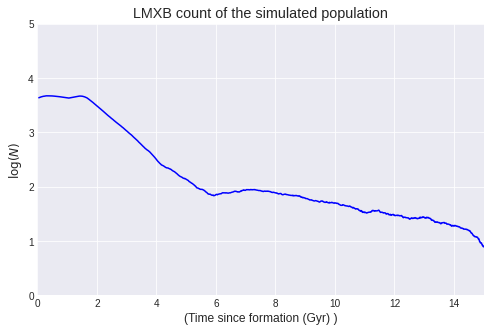

In [618]:
c = np.array(count_x).copy()
f = 1
count_x = [c[i] for i in range(len(c)) if i%f==0 ]
t = np.arange(0, t_end, dt*f)

plt.figure( figsize = (8,5) )
# plt.scatter(t/1e9, np.log10(count_x), 1)
# plt.plot(t/1e9, np.log10(count_x))
plt.ylabel('$\log (N)$')
plt.xlabel('(Time since formation (Gyr) )')
plt.title('LMXB count of the simulated population')


xdata = (t/1e9)[5:]
ydata = count_x[5:]
y_fit = pd.Series(ydata).rolling(window=200, min_periods=0, center=True).mean()
plt.plot((t/1e9)[5:], np.log10(y_fit), 'b-')
plt.xlim(0,15)
plt.ylim(0,5)
plt.show()

count_x = c.copy()

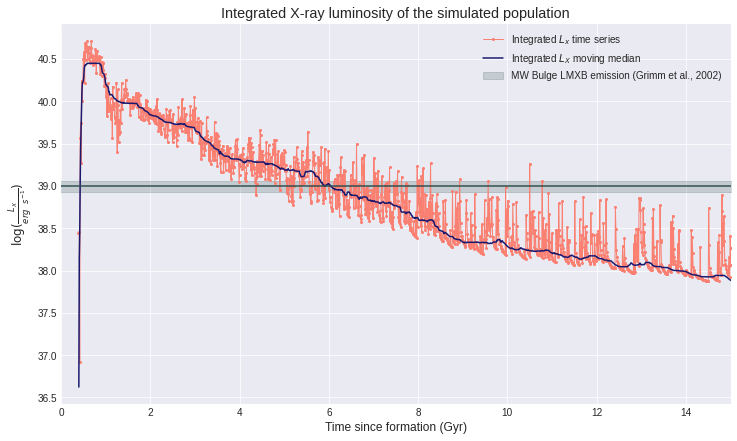

In [412]:
c = np.array(L_x_int).copy()

f = 1
L_x_int = [c[i] for i in range(len(c)) if i%f==0 ]
t = np.arange(0, t_end, dt*f)

plt.figure( figsize = (12,7) )
plt.plot(t/1e9, np.log10(L_x_int), '-o', c="salmon", ms=2, linewidth = 1, label = r'Integrated $L_x$ time series', zorder=1)
plt.ylabel(r'$\log( \frac{L_{X}}{erg\ \ s^{-1}})$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Integrated X-ray luminosity of the simulated population')
# plt.show()

xdata = (t/1e9)
ydata = L_x_int
y_fit = pd.Series(ydata).rolling(window=70, min_periods=0, center=True).median()
plt.plot(t/1e9, np.log10(y_fit), c='midnightblue', label = r'Integrated $L_X$ moving median', zorder=5)


L_xint = y_fit
Lx_obs = 1e39     ## erg/s     ###Grimm 2002
t_agree_x = interpolate.InterpolatedUnivariateSpline(t/1e9, y_fit-Lx_obs).roots()[0:]
y_new = [np.log10(Lx_obs)]*len(t_agree_x)
u = np.log10(Lx_obs + 1.5e38)
l = np.log10(Lx_obs - 1.5e38)
err = np.array([[np.log10(Lx_obs)-l, u-np.log10(Lx_obs)]]*len(y_new)).T
line = newline( [t_agree_x[0], y_new[0]], [t_agree_x[-1], y_new[-1]],
               1, "darkslategray", r"MW Bulge LMXB emission (Grimm et al., 2002)" )
plt.fill_between(line.get_data()[0], l, u, alpha = 0.2, edgecolor='darkslategray', facecolor='darkslategray', linewidth=1,
                 label = r"MW Bulge LMXB emission (Grimm et al., 2002)", zorder=1)

plt.xlim(0,15)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig("L_x_comp.pdf")
plt.show()

L_x_int = c.copy()

In [826]:
interpolate.InterpolatedUnivariateSpline(t/1e9, y_fit-Lx_obs).roots()

array([ 0.22735522, 11.30921487, 11.36227262, 11.38770173, 11.73078855,
       11.75921182, 11.82122457, 12.110623  ])

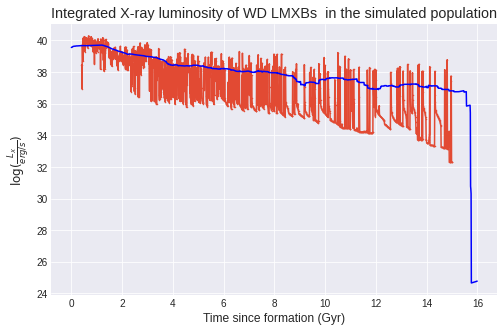

In [351]:
c = np.array(L_x_wd).copy()

f = 1
L = [c[i] for i in range(len(c)) if i%f==0 ]
t = np.arange(0, t_end, dt*f)

# t = np.arange(0, t_end, dt)
plt.figure( figsize = (8,5) )
plt.scatter(t/1e9, np.log10(L), 1 )
plt.plot(t/1e9, np.log10(L))
plt.ylabel(r'$\log( \frac{L_{X}}{erg/s})$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Integrated X-ray luminosity of WD LMXBs  in the simulated population')
# plt.show()

xdata = (t/1e9)
ydata = L
y_fit = pd.Series(ydata).rolling(window=150, min_periods=0, center=True).mean()
plt.plot(t/1e9, np.log10(y_fit), 'b-')
# plt.ylim(32,40)
plt.show()

L_xwd_int = y_fit

L_x_wd = c.copy()

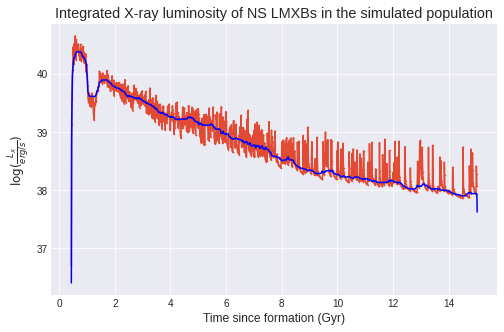

In [352]:
c = np.array(L_x_ns).copy()

f = 1
L = [c[i] for i in range(len(c)) if i%f==0 ]
t = np.arange(0, t_end, dt*f)

# t = np.arange(0, t_end, dt)
plt.figure( figsize = (8,5) )
plt.scatter(t/1e9, np.log10(L), 1 )
plt.plot(t/1e9, np.log10(L))
plt.ylabel(r'$\log( \frac{L_{X}}{erg/s})$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Integrated X-ray luminosity of NS LMXBs in the simulated population')
# plt.show()

xdata = (t/1e9)
ydata = L
y_fit = pd.Series(ydata).rolling(window=50, min_periods=0, center=True).median()
plt.plot(t/1e9, np.log10(y_fit), 'b-')
# plt.ylim(32,40)
plt.show()

L_xns_int = y_fit

L_x_ns = c.copy()

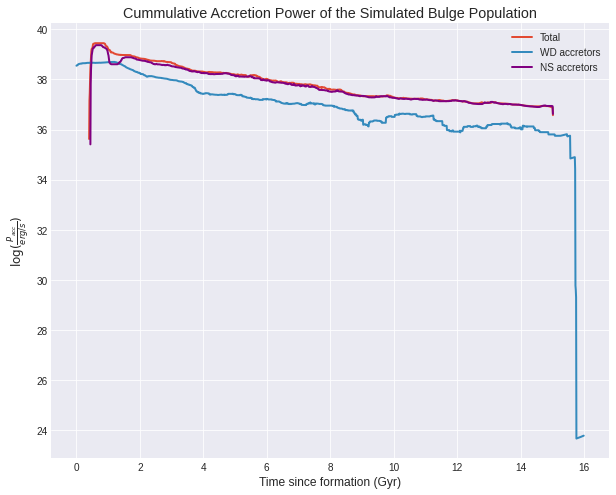

In [353]:
t = np.arange(0, t_end, dt)
plt.figure( figsize = (10,8) )
plt.plot(t/1e9, np.log10(L_xint*0.1), label = "Total", linewidth=2)
plt.plot(t/1e9, np.log10(L_xwd_int*0.1), label = "WD accretors", linewidth=2)
plt.plot(t/1e9, np.log10(L_xns_int*0.1), label = "NS accretors", c='purple', linewidth=2)
plt.ylabel(r'$\log( \frac{P_{acc}}{erg/s})$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Cummulative Accretion Power of the Simulated Bulge Population')
plt.legend()
plt.savefig("L_X_WD_NS.pdf")
plt.show()

t_agree =  4.68


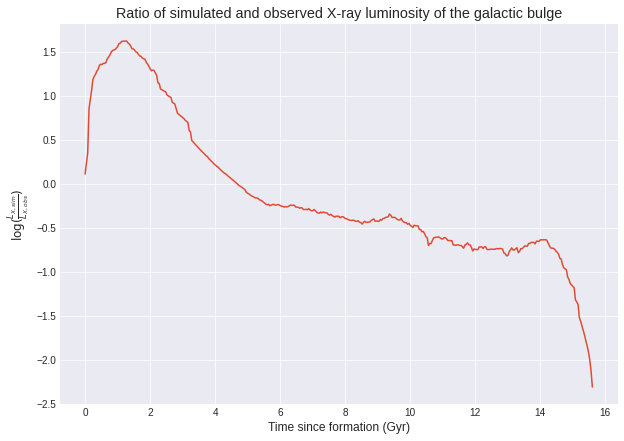

t_agree =  []


In [611]:
Lx_obs = 2e39    ## erg/s
Lx_ratio = L_xint/Lx_obs

t_agree_x = t[ find_nearest(np.log10(Lx_ratio), 0) ]/1e9
print("t_agree = ", t_agree_x)

plt.figure( figsize = (10,7) )
li = plt.plot(t/1e9, np.log10(Lx_ratio))
plt.ylabel(r'$\log( \frac{L_{X,sim}}{L_{X,obs}})$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Ratio of simulated and observed X-ray luminosity of the galactic bulge')
plt.show()


x, y = li[0].get_data()
yToFind = 0
yreduced = np.array(y) - yToFind
freduced = interpolate.UnivariateSpline(x, yreduced, s=0)

t_agree_gamma = freduced.roots()
print("t_agree = ", t_agree_gamma)

## Total accretion power calculations

In [16]:
t = np.arange(0, t_end, dt)
P_ns = np.zeros( int(t_end/dt) )
P_wd = np.zeros( int(t_end/dt) )
aic = np.zeros( int(t_end/dt) )

for i in range( len(ehists) ):
    if len(ehists[i]) != 18:
        for j in range( np.shape(ehists[i])[0] -1 ):
            if (ehists[i][j,5] in [10,11,12] and ehists[i][j,6]>0):    ## if primary is an accreting WD or NS
                P_wd[ int(ehists[i][j,0]*1e6/dt) ] += np.abs(ehists[i][j,11])/0.2
            if (ehists[i][j,5] == 13 and (ehists[i][j,17] == 1 or ehists[i][j,17] == 2) and ehists[i][j,6]>0):            ## if primary is an accreting WD or NS
                P_ns[ int(ehists[i][j,0]*1e6/dt) ] += np.abs(ehists[i][j,11])/0.2
            if ehists[i][j,17] == 1 and ehists[i][j-1,17] == 0:
                aic[ int(ehists[i][j,0]*1e6/dt) ] +=1

P_wd *= (f_bulge)
P_ns *= (f_bulge)

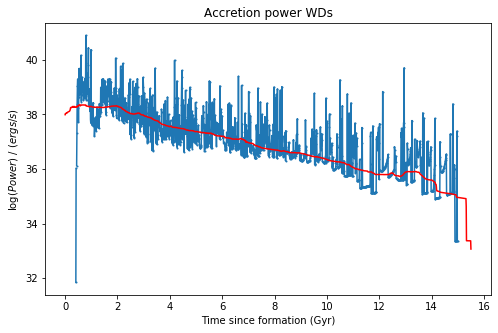

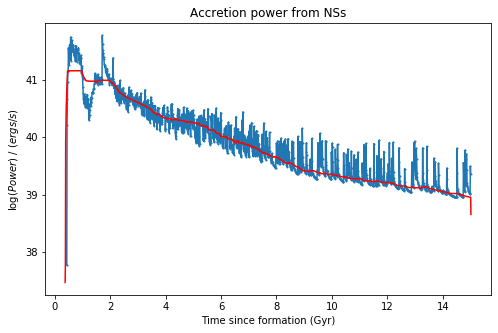

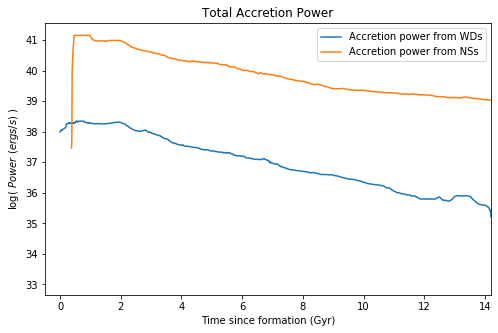

In [40]:
## t = np.arange(0, t_end, dt)
plt.figure( figsize = (8,5) )
plt.scatter(t/1e9, np.log10(P_wd), 1 )
plt.plot(t/1e9, np.log10(P_wd))
plt.ylabel('$\log(Power)\ /\ (ergs/s)$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Accretion power WDs')
# plt.show()

xdata = (t/1e9)
ydata = P_wd
y_wd = pd.Series(ydata).rolling(window=300, min_periods=0, center=True).median()
plt.plot(t/1e9, np.log10(y_wd), 'r-')
# plt.ylim(32,40)
plt.show()

#####################################

## t = np.arange(0, t_end, dt)
plt.figure( figsize = (8,5) )
plt.scatter(t/1e9, np.log10(P_ns), 1 )
plt.plot(t/1e9, np.log10(P_ns))
plt.ylabel('$\log(Power)\ /\ (ergs/s)$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Accretion power from NSs')
# plt.show()

xdata = (t/1e9)
ydata = P_ns
y_ns = pd.Series(ydata).rolling(window=100, min_periods=0, center=True).median()
plt.plot(t/1e9, np.log10(y_ns), 'r-')
# plt.ylim(32,40)
plt.show()


plt.figure( figsize = (8,5) )
# plt.scatter(t/1e9, np.log10(L_x), 1 )
plt.plot(t/1e9, np.log10(y_wd), label='Accretion power from WDs')
plt.plot(t/1e9, np.log10(y_ns), label='Accretion power from NSs')
# plt.plot(t/1e9, np.log10(y_ns+y_wd), label='Total accretion power')
plt.xlim(-0.5,14.2)
# plt.ylim(36,42)
plt.ylabel('$\log( \ Power \ (ergs/s) \ )$')
plt.xlabel('Time since formation (Gyr)')
plt.title('Total Accretion Power')
plt.legend()
plt.show()

### AIC events vs. Time

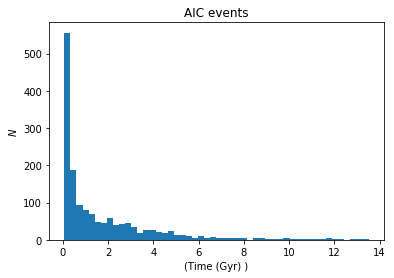

In [107]:
msp = np.loadtxt("MSPs_final_imp.dat")
plt.hist(msp[:,3]/1e3,50);
plt.ylabel('$N$')
plt.xlabel('(Time (Gyr) )')
plt.title('AIC events')
plt.show()

### AIC rate in the bulge

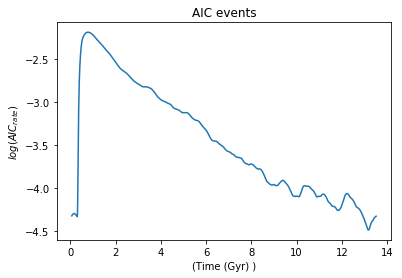

In [104]:
msp = np.loadtxt("MSPs_final_imp.dat")
hist, bins = np.histogram(msp[:,3]/1e3, bins=1500)
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

conv=np.fft.ifft(np.fft.fft(hist)*np.fft.fft(sfr)*dt/M_sim)

plt.plot(center, np.log10(conv*1e-5))
plt.ylabel('$log(AIC_{rate})$')
plt.xlabel('(Time (Gyr) )')
plt.title('AIC events')
plt.show()

### Chris & Harrison

In [6]:
b = np.arange(7.5,9.6, 0.05)[0:41]
B = [10**round(item,3) for item in b for i in range(int(50))]
T = np.zeros( len(B) )
P = np.zeros( len(T) )


for i in range( len(ehists) ):
    if round(np.log10(ehists[i][0,13]),3) in np.log10(B):
        for j in range( np.shape(ehists[i])[0] ):
            if ehists[i][j,4] == 13 and ehists[i][j,5] == 0.0 and ehists[i][j-1,5] > 0.0:
                for k in range( len(B) ):
                    if np.log10(B[k]) == round(np.log10(ehists[i][0,13]),3) and T[k]==0:
                        T[k] = ehists[i][j,0]
                        P[k] = ehists[i][j,11]
                        break


In [4]:
tpb = np.stack((T,P,np.log10(B)), axis=1)

In [5]:
np.savetxt('tpb_withsfr.dat', tpb, delimiter='\t', fmt='%.2e')

## Luminosity distribution, Power, $P-\dot{P}$ and $P-B$ w.r.t. time

In [356]:
t = np.arange(0, t_end, 1e7)

dNdL_gamma = []
L_g_noaic = []
P = []
P_dot = []
Power = []
B = []
age = []
dNdL_x = []
dNdL_xwd = []
dNdL_xns = []

for time in t:
    L_gi = []
    L_noaic = []
    L_xi = []
    L_xns = []
    L_xwd = []
    p = []
    p_dot = []
    power = []
    b = []
    for i in range( len(ehists) ):
        break1 = False
        break2 = False
        onewd = False
        aic = False
        if len(ehists[i]) != 18:
            for j in range( np.shape(ehists[i])[0] ):
                if ehists[i][j,5] == 12:
                    onewd = True
                if ehists[i][j,5] == 13 and onewd == True:
                    aic = True
            for j in range( np.shape(ehists[i])[0] ):
#                 print(aic)
                if type(ehists[i][j,15]) != str:
                    if ehists[i][j,0]*1e6 == time: 
                        if ehists[i][j,5] == 13 and ehists[i][j,15] > 0 and aic == True:
#                             print(np.abs(ehists[i][j,15]), ehists[i][j,12], "AIC")
                            p.append(ehists[i][j,12])
                            p_dot.append(ehists[i][j,13])
                            power.append( 1/ehists[i][j,12]**2 )
                            b.append(ehists[i][j,14])
                            L_gi.append( np.abs(ehists[i][j,15]) ) 
                        if ehists[i][j,5] == 13 and ehists[i][j,15] > 0 and aic == False:
#                             print(np.abs(ehists[i][j,15]), ehists[i][j,12], "Not AIC")
                            L_noaic.append( np.abs(ehists[i][j,15]) ) 
                        break1 = True
                        
                
                if ehists[i][j,0]*1e6 == time and (ehists[i][j,5] == 13 or ehists[i][j,5] in [10,11,12]) and abs(ehists[i][j,6])>0:  ## if primary is an accreting WD or NS
#                 L_x[ int(ehists[i][j,0]*1e6/dt) ] += np.abs(ehists[i][j,11])
                    if abs(ehists[i][j,6])>0:
                        eta = 0.1
                        L = eta * G * ehists[i][j,3] * abs(ehists[i][j,6]) / (ehists[i][j,4]*695700)
                        L = L * 2e33 * (1e5)**2 / (3.154e+7)**3  # ergs/s
#                         R_sch = 2 * G * ehists[i][j,3] / c**2
#                         eta = R_sch / (ehists[i][j,4]*695700)
#                         L_bol = eta * 0.5 * abs(ehists[i][j,6]) * c**2
#                         L = 0.1 * L_bol
#                         L = L * 2e33 * (1e5)**2 / (3.154e+7)**3  # ergs/s
                    else:
                        L = 0
                    if L>1e36:
                        L_xi.append( L ) 
                    if ehists[i][j,5] in [10,11,12]:
                        L_xwd.append( L ) 
                    if ehists[i][j,5] == 13:
                        L_xns.append( L )
                    break2 = True
               
                if break1 == True and break2 == True:
                    break
                    
    dNdL_gamma.append( np.array(L_gi) )
    L_g_noaic.append( np.array(L_noaic) )
    dNdL_x.append( np.array(L_xi) )
    dNdL_xwd.append( np.array(L_xwd) )
    dNdL_xns.append( np.array(L_xns) )
    Power.append( sum(power) )
    P.append( p )
    P_dot.append( p_dot )
    B.append( b )

KeyboardInterrupt: 

### $P, \ \dot{P},\ L \ \& \ B$ hist

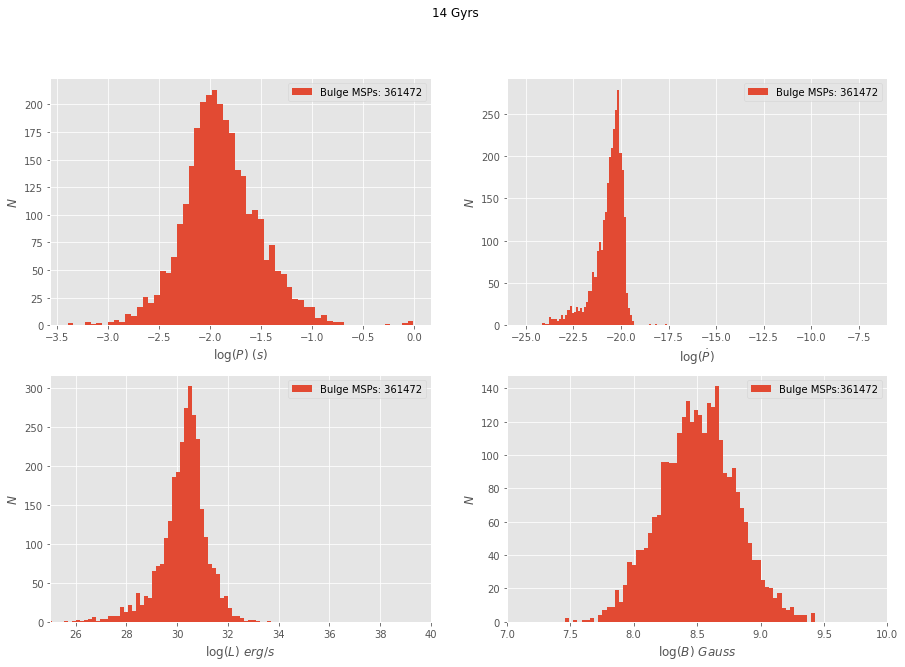

In [278]:
def live_plot(p, p_dot, L, B, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    fig.suptitle(str(title)+' Gyrs')
    
    plt.subplot(221)
    n, bins, p = plt.hist(np.log10(p), 60, label = 'Bulge MSPs: %i'%(len(p)*f_bulge))
    plt.xlabel('$\log(P)\ (s)$')
    plt.ylabel('$ N $')
#     plt.xlim(-4, 0)
    plt.legend()
    
    plt.subplot(222)
    plt.hist(np.log10(p_dot), 60, label = 'Bulge MSPs: %i'%(len(p_dot)*f_bulge))
    plt.xlabel(r"$\log(\dot{P})$")
    plt.ylabel(r"$N $")
    plt.xlim(-26,-6)
    plt.legend()
    
    plt.subplot(223)
    plt.hist(np.log10(L), 60, label = 'Bulge MSPs: %i'%(len(p_dot)*f_bulge))
    plt.xlabel(r"$\log(L) \ erg/s$")
    plt.ylabel(r"$N $")
    plt.xlim(25,40)
    plt.legend()
    
    plt.subplot(224)
    plt.hist(np.log10(B), 60, label = 'Bulge MSPs:%i'%(len(p_dot)*f_bulge))
    plt.xlabel(r"$\log(B) \ Gauss$")
    plt.ylabel(r"$N $")
    plt.xlim(7,10)
    plt.legend()
    plt.show()
    
    return
    

for time in range(15):
    live_plot(P[time], P_dot[time], dNdL_gamma[time], B[time],(15,10), time)

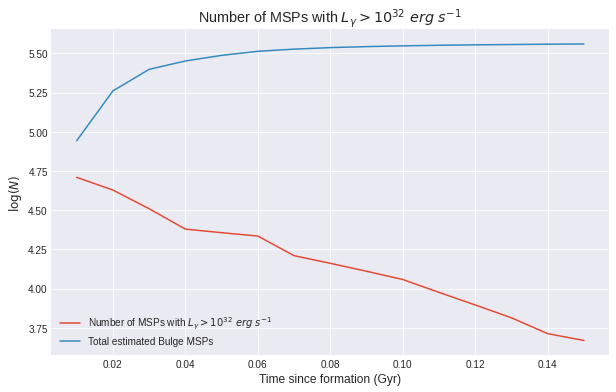

In [355]:
y = []
z = []
for time in range(16):
    j = np.log10(dNdL_gamma[time])
    y.append( int(sum(i > 32 for i in j)*f_bulge) )
    j = np.log10(dNdL_gamma[time])
    z.append( int(sum(i > 0 for i in j)*f_bulge) )
    
plt.figure(figsize=(10,6))
plt.plot(t[0:16]/1e9, np.log10(y), label=r'Number of MSPs with $L_\gamma > 10^{32}\ erg\ s^{-1}$ ')
plt.plot(t[0:16]/1e9, np.log10(z), label = "Total estimated Bulge MSPs")
plt.ylabel('$\log(N)$')
plt.xlabel('Time since formation (Gyr)')
plt.title(r'Number of MSPs with $L_\gamma > 10^{32}\ erg\ s^{-1}$ ')
plt.legend()
# plt.savefig("Nmsps.pdf")
plt.show()

### B distribution

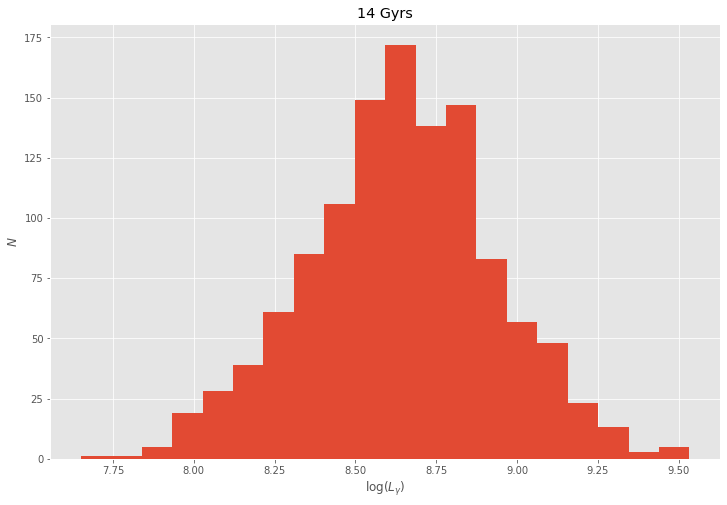

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    n, bins, p = plt.hist(np.log10(data),20)
    plt.title(str(title)+' Gyrs')
    plt.xlabel(r"$\log(B)$")
    plt.ylabel(r"$N $")
    plt.show();
    
for time in range(1, 15):
    live_plot(B[time], (12,8), time)

## $\gamma$-ray luminosity hist

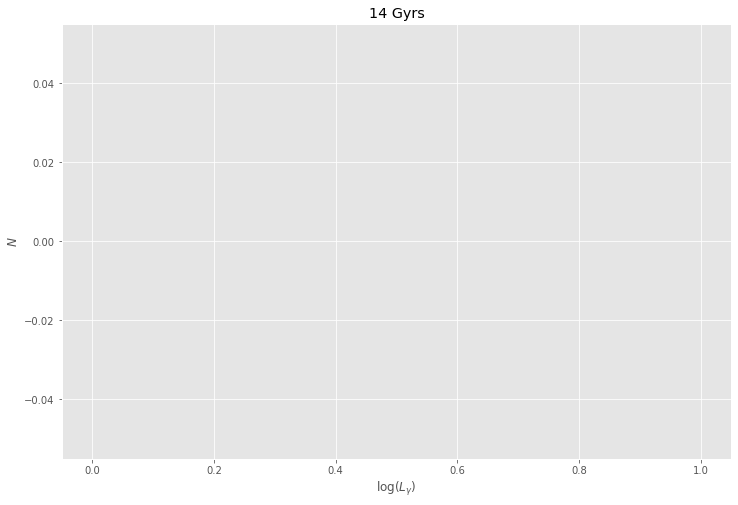

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    n, bins, p = plt.hist(np.log10(data), 60)
#     plt.xlim(20, 40)
#     plt.ylim(0, 350)

    plt.title(str(title)+' Gyrs')
    plt.xlabel(r"$\log(L_\gamma)$")
    plt.ylabel(r"$N $")
    plt.show();
    
for time in range(1, 15):
#     live_plot(dNdL_gamma[time], (12,8), time)
    live_plot(L_g_noaic[time], (12,8), time)



## X-ray Luminosity distribution

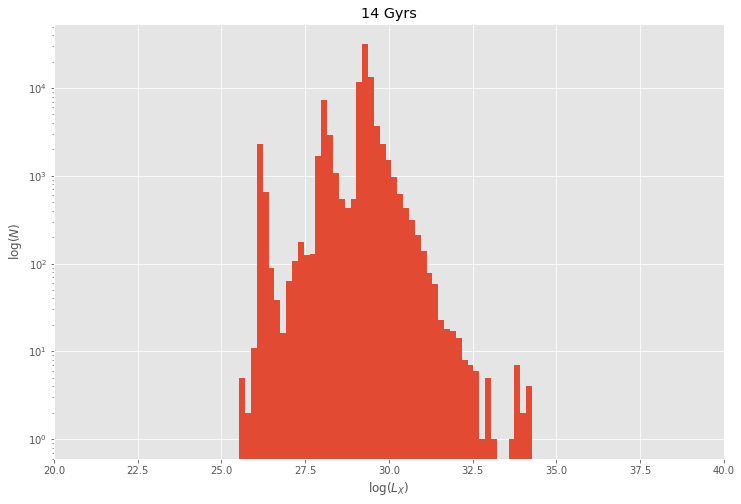

In [384]:
from IPython.display import clear_output

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    n, bins, p = plt.hist(np.log10(data), log=True,  bins = 50)

#     n, edges = np.histogram(np.log10(data), 300)
#     plt.scatter( edges[:-1], np.log10(edges[:-1]) )
    plt.xlim(20, 40)
#     plt.ylim(0, 350)

    plt.title(str(title)+' Gyrs')
    plt.xlabel(r"$\log(L_X)$")
    plt.ylabel(r"$\log(N) $")
    plt.show();
    
for time in range(1, 15):
    live_plot(dNdL_xwd[time], (12,8), time)

# time = 13
# live_plot(dNdL_x[time], (12,8), time)

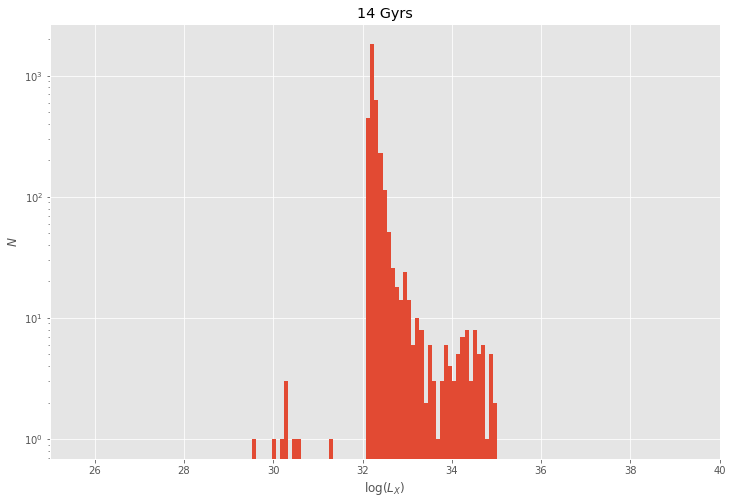

In [386]:
def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    n, bins, p = plt.hist(np.log10(data), log=True, bins=60)

#     n, edges = np.histogram(np.log10(data), 300)
#     plt.scatter( edges[:-1], np.log10(edges[:-1]) )
    plt.xlim(25, 40)
#     plt.ylim(0, 350)

    plt.title(str(title)+' Gyrs')
    plt.xlabel(r"$\log(L_X)$")
    plt.ylabel(r"$N $")
    plt.show();
    
for time in range(1, 15):
    live_plot(dNdL_xns[time], (12,8), time)

# time = 12
# live_plot(dNdL_x[time], (12,8), time)

#### $P-\dot{P}$ and $\gamma-ray$ Luminosity hists

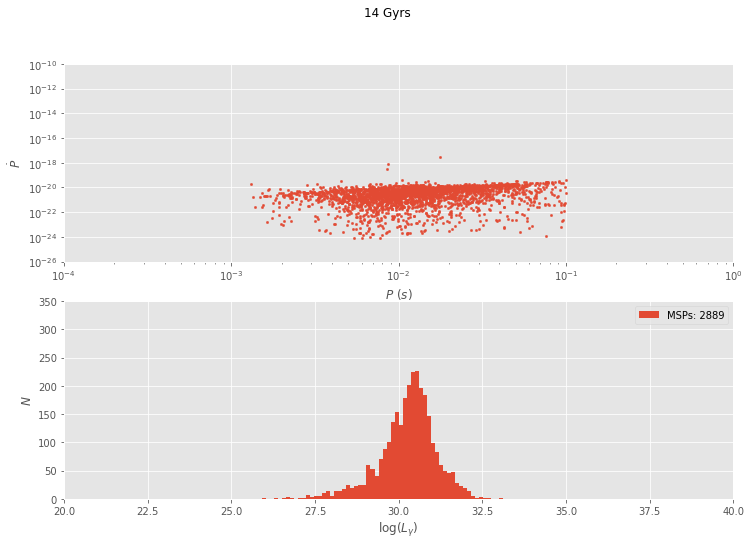

In [255]:
def live_plot(p, p_dot, data, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    fig.suptitle(str(title)+' Gyrs')
    
    plt.subplot(211)
    plt.scatter( p, p_dot, 5 )
    plt.xlabel('$P \ (s)$')
    plt.ylabel('$ \dot{P} $')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-26,1e-10)
    plt.xlim(1e-4, 1)
    
    plt.subplot(212)
    n, bins, p = plt.hist(np.log10(data), 60, label = 'MSPs: %i'%len(p))
    plt.xlabel(r"$\log(L_\gamma)$")
    plt.ylabel(r"$N $")
    plt.ylim(0, 350)
    plt.xlim(20, 40)
    plt.legend()
    plt.show();

    
    
for time in range(15):
    live_plot(P[time], P_dot[time], dNdL_gamma[time], (12,8), time)

## $L_\gamma \frac{dN}{dL_\gamma} $

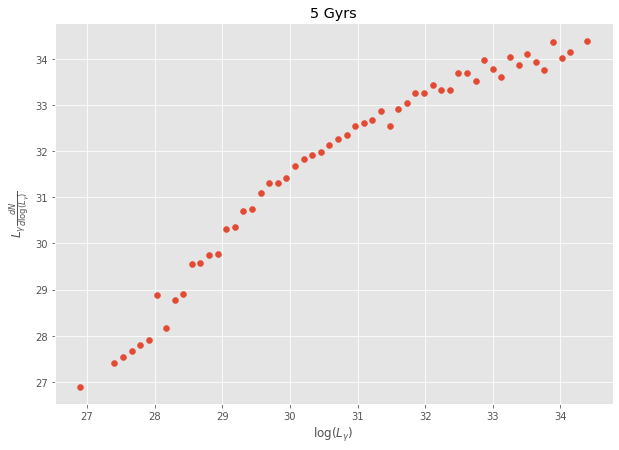

In [427]:
time = 5
a = dNdL_gamma[time]
n, edges = np.histogram(np.log10(a),60)

plt.figure(figsize=(10,7))
plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]) )
# plt.plot( edges[:-1], np.log10(n*10**edges[:-1]) )
plt.title(str(time) + ' Gyrs')
plt.xlabel(r"$\log(L_\gamma)$")
plt.ylabel(r"$L_\gamma\frac{dN}{d \log(L_\gamma)}$")
# plt.savefig("L dNdL gamma")
plt.show();

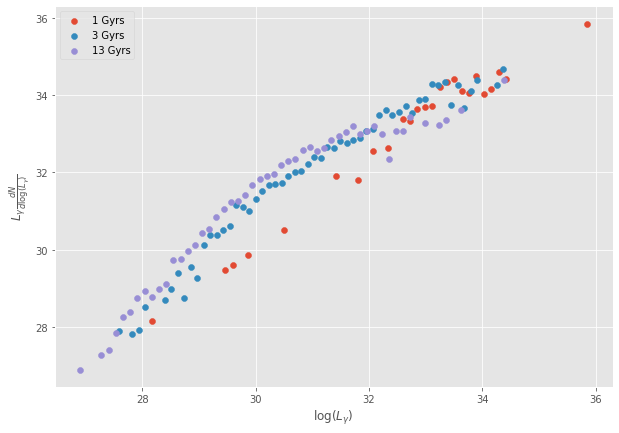

In [430]:
plt.figure(figsize=(10,7))

time = 1
a = dNdL_gamma[time]
n, edges = np.histogram(np.log10(a),60)
plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]), label = str(time) + ' Gyrs'  )

time = 3
a = dNdL_gamma[time]
n, edges = np.histogram(np.log10(a),60)
plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]), label = str(time) + ' Gyrs'  )

# time = 9
# a = dNdL_gamma[time]
# n, edges = np.histogram(np.log10(a),60)
# plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]), label = str(time) + ' Gyrs'  )

time = 13
a = dNdL_gamma[time]
n, edges = np.histogram(np.log10(a),60)
plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]), label = str(time) + ' Gyrs' )



plt.xlabel(r"$\log(L_\gamma)$")
plt.ylabel(r"$L_\gamma\frac{dN}{d \log(L_\gamma)}$")
plt.legend()
plt.show();

## $L_x \frac{dN}{dL_x} $

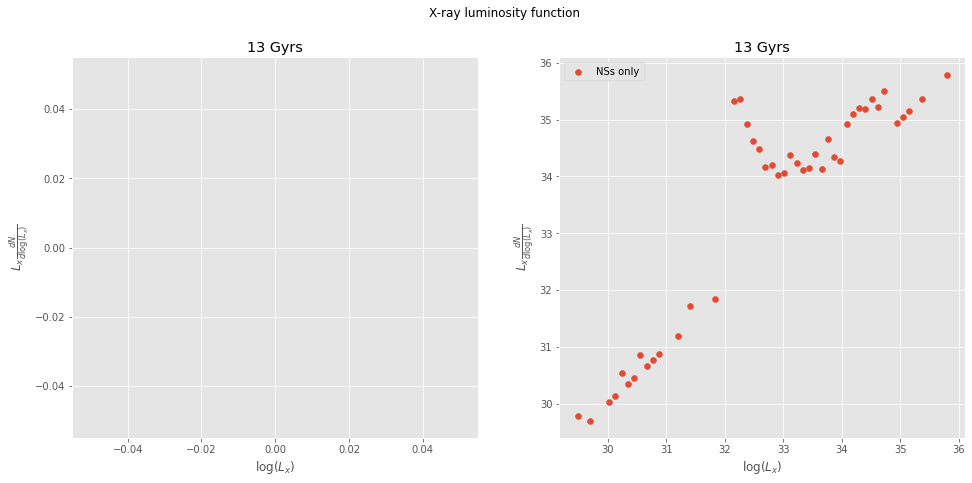

In [434]:
plt.figure(figsize=(16,7))
plt.suptitle("X-ray luminosity function")

time = 13

a = dNdL_x[time]
n, edges = np.histogram(np.log10(a),60)
plt.subplot(121)
plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]) )
# plt.plot( edges[:-1], np.log10(n*10**edges[:-1]) )
plt.title(str(time) + ' Gyrs')
plt.xlabel(r"$\log(L_x)$")
plt.ylabel(r"$L_x\frac{dN}{d \log(L_x)}$")

a = dNdL_xns[time]
n, edges = np.histogram(np.log10(a),60)
plt.subplot(122)
plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]), label="NSs only" )
# plt.plot( edges[:-1], np.log10(n*10**edges[:-1]) )
plt.title(str(time) + ' Gyrs')
plt.xlabel(r"$\log(L_x)$")
plt.ylabel(r"$L_x\frac{dN}{d \log(L_x)}$")
plt.legend()

# plt.savefig("L dNdL X")
plt.show();

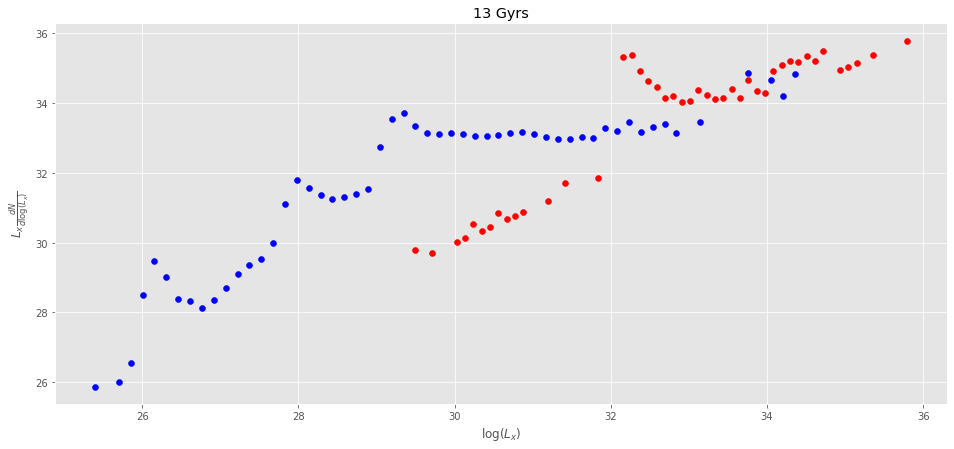

In [441]:
time = 13

plt.figure(figsize=(16,7))
a = dNdL_xwd[time]
n, edges = np.histogram(np.log10(a),60)
plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]), c='blue' )

a = dNdL_xns[time]
n, edges = np.histogram(np.log10(a),60)
plt.scatter( edges[:-1], np.log10(n*10**edges[:-1]), color='red')
# plt.plot( edges[:-1], np.log10(n*10**edges[:-1]) )
plt.title(str(time) + ' Gyrs')
plt.xlabel(r"$\log(L_x)$")
plt.ylabel(r"$L_x\frac{dN}{d \log(L_x)}$")
plt.show()

#### B vs P

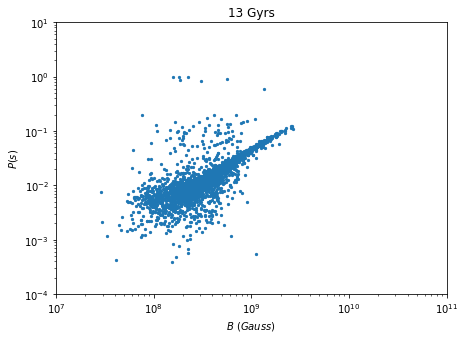

In [30]:
def live_plot(b, p, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter( b, p, 5 )
    plt.xlabel('$B \ (Gauss)$')
    plt.ylabel('$ P (s) $')
    plt.title(str(time)+' Gyrs')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim(1e-4, 10)
    plt.xlim(1e7, 1e11)
#     plt.savefig("P-B distribution at t=t_now")
    plt.show()
    
    
# for time in range(15):
#     live_plot(B[time], P[time], (12,8), time)

time = 13
live_plot(B[time], P[time], (12,8), time)

#### $ P-\dot{P}$

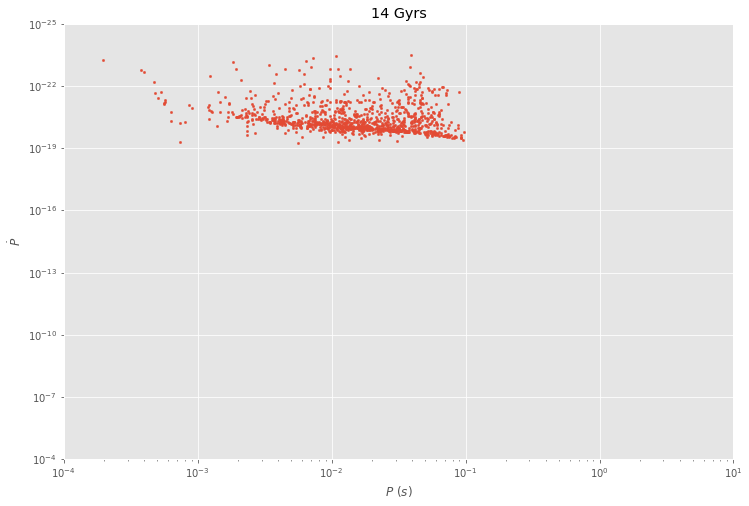

In [442]:
def live_plot(p, p_dot, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter( p, p_dot, 5 )
    plt.xlabel('$P \ (s)$')
    plt.ylabel('$ \dot{P} $')
    plt.title(str(title)+' Gyrs')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim(1e-4, 1e-25)
    plt.xlim(1e-4, 1e1)
    plt.show();

    
    
for time in range(15):
    live_plot(P[time], P_dot[time], (12,8), time)

#### Power

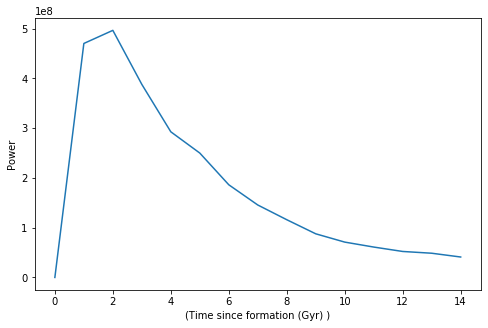

In [28]:
t = np.arange(0, t_end, 1e9)
plt.figure( figsize = (8,5) )
# plt.scatter(t/1e9, np.log10(count_msp), 1)
plt.plot(t/1e9, Power)
plt.ylabel('Power')
plt.xlabel('(Time since formation (Gyr) )')
plt.show()

### Sim vs. ATNF

In [246]:
atnf = pd.read_csv("atnf_pulsars.txt", sep="|")

In [264]:
L_atnf = []
for i in range(0, len(atnf['e_dot'])):
    if atnf['period'][i]*1e3<100:
        L_atnf.append(atnf['e_dot'][i])


In [265]:
def L_gamma(time):
    L = []
    for i in range( len(ehists) ):
        if len(ehists[i]) != 16:
            for j in range( np.shape(ehists[i])[0] ):
                if ehists[i][j,0]*1e6 == time and ehists[i][j,11] < 100e-3 and ehists[i][j,4] == 13 and ehists[i][j,14] > 0 and ehists[i][j,15] == 1:
#                 if ehists[i][j,0]*1e6 == time and ehists[i][j,4] == 13:
                        L.append( np.abs(ehists[i][j,14]) ) 
    return L

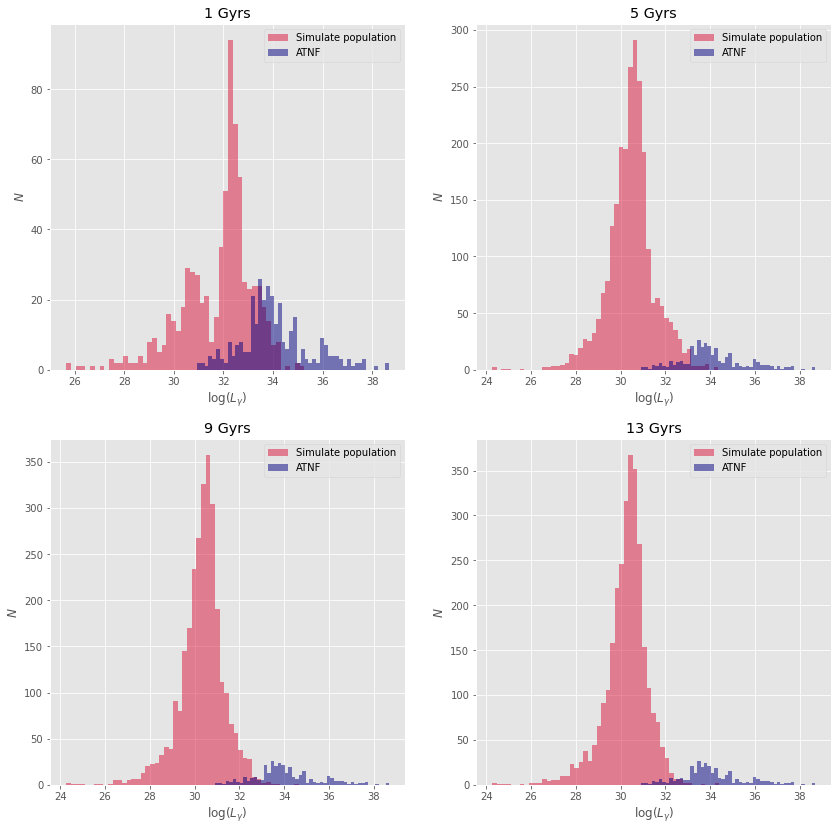

In [276]:
fig = plt.figure(figsize=(14,14))
k = 1
for time in range(1, 15, 4):  
    clear_output(wait=True)
    plt.subplot(2,2,k)
    plt.hist(np.log10( dNdL_gamma[time] ), 50, alpha=0.5, color='crimson', label='Simulate population')
    plt.hist(np.log10( L_atnf ), 50, alpha=0.5, color='navy', label='ATNF')
    plt.xlabel(r"$\log(L_\gamma)$")
    plt.ylabel(r"$N $")
    plt.title(str(time)+' Gyrs')
#     plt.xlim(25, 38)
    k+=1
    plt.legend()
# plt.savefig()
plt.show();

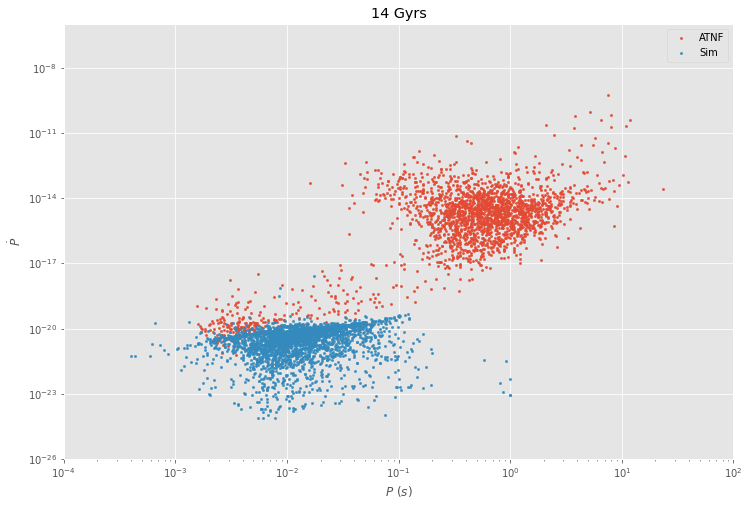

In [275]:
for t_sim in range(1, 15):  
    clear_output(wait=True)
    fig = plt.figure(figsize=(12,8))
    plt.scatter( atnf["period"], atnf["period_dot"], 5 , label = "ATNF")
#     t_sim = 11
    plt.scatter( P[t_sim], P_dot[t_sim], 5, label = "Sim" )
    plt.xlabel('$P \ (s)$')
    plt.ylabel('$ \dot{P} $')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(str(t_sim)+' Gyrs')
    plt.ylim(1e-26,1e-6)
    plt.xlim(1e-4, 1e2)
    plt.legend()
    plt.show()

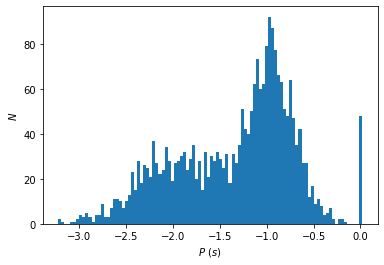

In [97]:
for t_sim in range(1, 13): 
    clear_output(wait=True)
    plt.hist(np.log10( P[t_sim] ), 100)
    plt.xlabel('$P \ (s)$')
    plt.ylabel(r"$N $")
    plt.show()

# ATNF

In [98]:
import astropy.coordinates as coord
import astropy.units as u

In [266]:
data = pd.read_csv("atnf_pulsar_cat.txt",sep=';')

In [195]:
data

,#,Gl,Gb,P0,P1,BSURF,EDOT,EDOTD2,Unnamed: 8
0,1,123.200,6.563,NAN,NAN,NAN,NAN,NAN,NaN
1,2,151.975,-55.155,NAN,NAN,NAN,NAN,NAN,NaN
2,3,174.353,0.746,NAN,NAN,NAN,NAN,NAN,NaN
3,4,186.756,-4.495,NAN,NAN,NAN,NAN,NAN,NaN
4,5,264.804,-26.411,NAN,NAN,NAN,NAN,NAN,NaN
...,...,...,...,...,...,...,...,...,...
2807,2808,257.426,-4.983,11.370386,5.56e-14,2.54e+13,1.49e+30,NAN,NaN
2808,2809,33.579,-0.044,11.558713,0.00e+00,NAN,NAN,NAN,NaN
2809,2810,27.387,-0.007,11.788978,4.09e-11,7.03e+14,9.86e+32,1.07e+31,NaN
2810,2811,3.605,-62.883,12.122565,1.31e-14,1.28e+13,2.90e+29,1.62e+29,NaN


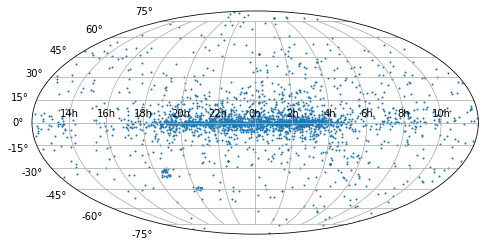

In [267]:
# ra = coord.Angle(data['ra'], u.hour)
# ra = ra.wrap_at(180*u.degree)
# dec = coord.Angle(data['dec'], u.degree)

l = coord.Angle(data['Gl'], u.degree)
l = l.wrap_at(180*u.degree)
b = coord.Angle(data['Gb'], u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(l.radian, b.radian, 1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

In [268]:
data = data[data.P0.astype(float)<100e-3]

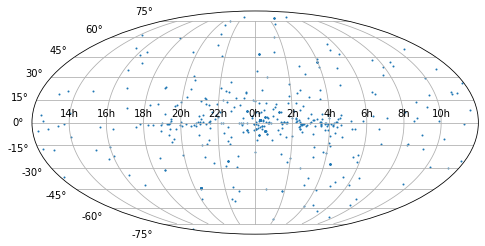

In [269]:
# ra = coord.Angle(data['ra'], u.hour)
# ra = ra.wrap_at(180*u.degree)
# dec = coord.Angle(data['dec'], u.degree)

l = coord.Angle(data['Gl'], u.degree)
l = l.wrap_at(180*u.degree)
b = coord.Angle(data['Gb'], u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(l.radian, b.radian, 1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

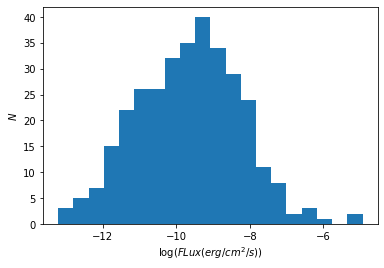

In [270]:
F_atnf = data['EDOTD2'].astype(float) / 3.086e+21**2
plt.hist(np.log10(F_atnf),20)
plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
plt.ylabel(r"$N $")
plt.show()

In [175]:
data['EDOTD2'].astype(float)

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
2807             NaN
2808             NaN
2809    1.070000e+31
2810    1.620000e+29
2811    3.380000e+28
Name: EDOTD2, Length: 2812, dtype: float64

In [151]:
data["pdot"]

0      3.570000e-13
1      4.800000e-21
2      2.740000e-14
3      3.180000e-14
4      4.030000e-12
           ...     
112    1.500000e-15
113    5.500000e-14
114    7.790000e-14
115    1.900000e-13
116    3.570000e-13
Name: pdot, Length: 117, dtype: float64

In [40]:
# time = 13.7e9
# L =[]
# for i in range( len(ehists) ):
#     if len(ehists[i]) != 16:
#         for j in range( np.shape(ehists[i])[0] ):
#             if ehists[i][j,0]*1e6 == time and ehists[i][j,11] < 100e-3 and ehists[i][j,4] == 13 and ehists[i][j,14] > 0 and ehists[i][j,15] == 1:
#                 L.append( np.abs(ehists[i][j,14]) ) 

time = 13e9
L =[]
for i in range( len(ehists) ):
    if len(ehists[i]) != 16:
        for j in range( np.shape(ehists[i])[0] ):
            if ehists[i][j,0]*1e6 == time and ehists[i][j,5] == 13 and ehists[i][j,12] < 100e-3 and ehists[i][j,15] > 0 and (ehists[i][j,17] == 1 or ehists[i][j,17] == 2):
                L.append( np.abs(ehists[i][j,15]) ) 

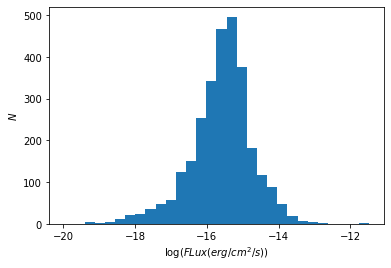

In [41]:
d_MWB = 2.469e+22      ##8 kpc in cm
# r = np.sqrt( d_MWB**2 +  loc_sorted[2]**2 )
# F = np.array(L)/(4*np.pi*r**2)
F = np.array(L)/(4*np.pi*d_MWB**2)

# plt.hist(np.log10(L), 30)
plt.hist(np.log10(F),30)
# plt.xlim(-13, -10)
# plt.ylim(0,10)
plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
plt.ylabel(r"$N $")
plt.show()

# Fermi 2PC

In [424]:
import astropy.coordinates as coord
import astropy.units as u

ModuleNotFoundError: No module named 'astropy'

In [425]:
data = pd.read_csv("fermi_2pc.txt",sep='|')

FileNotFoundError: [Errno 2] File fermi_2pc.txt does not exist: 'fermi_2pc.txt'

In [272]:
data

,Unnamed: 0,name,ra,dec,lii,bii,period,pdot,edot,flux,distance,luminosity,Unnamed: 12
0,NaN,PSR J1357-6429,13 57 02.4,-64 29 30,309.9227,-2.5141,166.17,3.570000e-13,3.070000e+36,3.388000e-11,2.500,2.5340e+34,NaN
1,NaN,PSR J0101-6422,01 01 11.1,-64 22 30,301.1923,-52.7203,2.57,4.800000e-21,1.010000e+34,1.047000e-11,0.550,3.7900e+32,NaN
2,NaN,PSR J1413-6205,14 13 30.2,-62 05 37,312.3738,-0.7356,109.74,2.740000e-14,8.180000e+35,1.574000e-10,,,NaN
3,NaN,PSR J1410-6132,14 10 22.1,-61 31 59,312.1929,-0.0887,50.05,3.180000e-14,1.000000e+37,2.630000e-11,15.600,7.6580e+35,NaN
4,NaN,PSR J1119-6127,11 19 14.3,-61 27 49,292.1513,-0.5369,408.73,4.030000e-12,2.330000e+36,7.148000e-11,8.400,6.0350e+35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,NaN,PSR J1836+5925,18 36 13.7,+59 25 30,88.8752,24.9993,173.26,1.500000e-15,1.140000e+34,6.057000e-10,0.530,2.0360e+34,NaN
113,NaN,PSR J0248+6021,02 48 18.6,+60 21 35,136.9027,0.6974,217.11,5.500000e-14,2.120000e+35,5.163000e-11,2.000,2.4710e+34,NaN
114,NaN,PSR J2229+6114,22 29 05.7,+61 14 04,106.6475,2.9470,51.64,7.790000e-14,2.230000e+37,2.533000e-10,0.800,1.9390e+34,NaN
115,NaN,PSR J0205+6449,02 05 37.9,+64 49 43,130.7192,3.0846,65.73,1.900000e-13,2.640000e+37,5.358000e-11,1.950,2.4380e+34,NaN


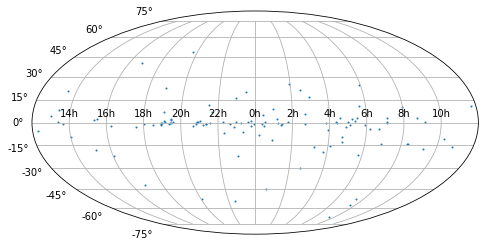

In [273]:
# ra = coord.Angle(data['ra'], u.hour)
# ra = ra.wrap_at(180*u.degree)
# dec = coord.Angle(data['dec'], u.degree)

l = coord.Angle(data['lii'], u.degree)
l = l.wrap_at(180*u.degree)
b = coord.Angle(data['bii'], u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(l.radian, b.radian, 1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

In [281]:
data = data[data.period.astype(float)<500]

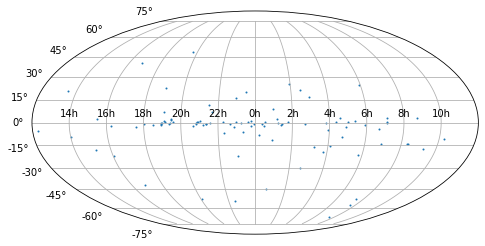

In [282]:
# ra = coord.Angle(data['ra'], u.hour)
# ra = ra.wrap_at(180*u.degree)
# dec = coord.Angle(data['dec'], u.degree)

l = coord.Angle(data['lii'], u.degree)
l = l.wrap_at(180*u.degree)
b = coord.Angle(data['bii'], u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(l.radian, b.radian, 1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

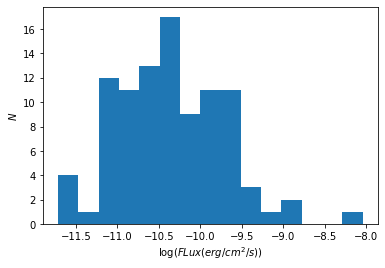

In [285]:
F_fermi2pc = data['flux'].astype(float)
plt.hist(np.log10(F_fermi2pc),15)
plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
plt.ylabel(r"$N $")
plt.show()

In [175]:
data['EDOTD2'].astype(float)

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
2807             NaN
2808             NaN
2809    1.070000e+31
2810    1.620000e+29
2811    3.380000e+28
Name: EDOTD2, Length: 2812, dtype: float64

In [151]:
data["pdot"]

0      3.570000e-13
1      4.800000e-21
2      2.740000e-14
3      3.180000e-14
4      4.030000e-12
           ...     
112    1.500000e-15
113    5.500000e-14
114    7.790000e-14
115    1.900000e-13
116    3.570000e-13
Name: pdot, Length: 117, dtype: float64

In [40]:
# time = 13.7e9
# L =[]
# for i in range( len(ehists) ):
#     if len(ehists[i]) != 16:
#         for j in range( np.shape(ehists[i])[0] ):
#             if ehists[i][j,0]*1e6 == time and ehists[i][j,11] < 100e-3 and ehists[i][j,4] == 13 and ehists[i][j,14] > 0 and ehists[i][j,15] == 1:
#                 L.append( np.abs(ehists[i][j,14]) ) 

time = 13e9
L =[]
for i in range( len(ehists) ):
    if len(ehists[i]) != 16:
        for j in range( np.shape(ehists[i])[0] ):
            if ehists[i][j,0]*1e6 == time and ehists[i][j,5] == 13 and ehists[i][j,12] < 100e-3 and ehists[i][j,15] > 0 and (ehists[i][j,17] == 1 or ehists[i][j,17] == 2):
                L.append( np.abs(ehists[i][j,15]) ) 

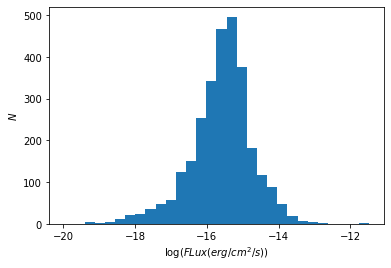

In [41]:
d_MWB = 2.469e+22      ##8 kpc in cm
# r = np.sqrt( d_MWB**2 +  loc_sorted[2]**2 )
# F = np.array(L)/(4*np.pi*r**2)
F = np.array(L)/(4*np.pi*d_MWB**2)

# plt.hist(np.log10(L), 30)
plt.hist(np.log10(F),30)
# plt.xlim(-13, -10)
# plt.ylim(0,10)
plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
plt.ylabel(r"$N $")
plt.show()

# Fermi 4FGL

In [253]:
import astropy.coordinates as coord
import astropy.units as u

In [286]:
data = pd.read_csv("fermi_4fgl.txt",sep='|')

In [287]:
data

,Unnamed: 0,name,ra,dec,spectrum_type,alt_gammaray_name_1,lii,bii,energy_flux,Unnamed: 9
0,NaN,4FGL J0000.3-7355,00 00 23.6,-73 55 19,PowerLaw,,307.7090,-42.7295,1.920100e-12,NaN
1,NaN,4FGL J0003.3+2511,00 03 19.8,+25 11 28,PowerLaw,,109.3816,-36.4115,2.248300e-12,NaN
2,NaN,4FGL J0003.6+3059,00 03 37.1,+30 59 23,LogParabola,3FGL J0003.4+3100,111.0045,-30.7720,2.080000e-12,NaN
3,NaN,4FGL J0004.0+5715,00 04 00.4,+57 15 28,PowerLaw,3FGL J0003.5+5721,116.5263,-5.0229,5.194800e-12,NaN
4,NaN,4FGL J0004.4-4001,00 04 28.4,-40 01 30,PowerLaw,,336.9915,-73.8453,2.177400e-12,NaN
...,...,...,...,...,...,...,...,...,...,...
5061,NaN,4FGL J0930.3+8612,09 30 23.9,+86 12 08,PowerLaw,3FGL J0930.2+8612,126.2873,29.5162,1.039300e-11,NaN
5062,NaN,4FGL J0054.4+8627,00 54 25.8,+86 27 11,PowerLaw,,122.9824,23.5816,5.349700e-12,NaN
5063,NaN,4FGL J1738.0+8717,17 38 00.2,+87 17 06,PowerLaw,3FGL J1739.0+8716,120.0147,27.9531,3.246100e-12,NaN
5064,NaN,4FGL J0140.6+8736,01 40 40.5,+87 36 22,PowerLaw,3FGL J0139.9+8735,123.4939,24.7884,2.813200e-12,NaN


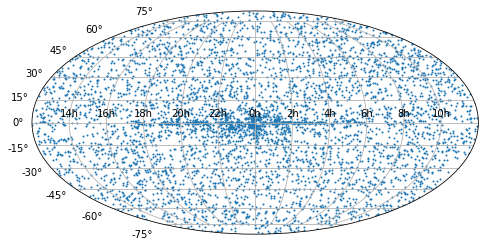

In [288]:
# ra = coord.Angle(data['ra'], u.hour)
# ra = ra.wrap_at(180*u.degree)
# dec = coord.Angle(data['dec'], u.degree)

l = coord.Angle(data['lii'], u.degree)
l = l.wrap_at(180*u.degree)
b = coord.Angle(data['bii'], u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(l.radian, b.radian, 1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

In [289]:
# data = data[data.P0.astype(float)<100e-3]

In [290]:
# # ra = coord.Angle(data['ra'], u.hour)
# # ra = ra.wrap_at(180*u.degree)
# # dec = coord.Angle(data['dec'], u.degree)

# l = coord.Angle(data['Gl'], u.degree)
# l = l.wrap_at(180*u.degree)
# b = coord.Angle(data['Gb'], u.degree)

# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection="mollweide")
# ax.scatter(l.radian, b.radian, 1)
# ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
# ax.grid(True)

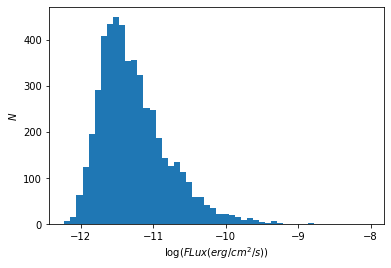

In [291]:
F_fermi4fgl = data['energy_flux'].astype(float)
plt.hist(np.log10(F_fermi4fgl),50)
plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
plt.ylabel(r"$N $")
plt.show()

In [151]:
data["pdot"]

0      3.570000e-13
1      4.800000e-21
2      2.740000e-14
3      3.180000e-14
4      4.030000e-12
           ...     
112    1.500000e-15
113    5.500000e-14
114    7.790000e-14
115    1.900000e-13
116    3.570000e-13
Name: pdot, Length: 117, dtype: float64

In [40]:
# time = 13.7e9
# L =[]
# for i in range( len(ehists) ):
#     if len(ehists[i]) != 16:
#         for j in range( np.shape(ehists[i])[0] ):
#             if ehists[i][j,0]*1e6 == time and ehists[i][j,11] < 100e-3 and ehists[i][j,4] == 13 and ehists[i][j,14] > 0 and ehists[i][j,15] == 1:
#                 L.append( np.abs(ehists[i][j,14]) ) 

time = 13e9
L =[]
for i in range( len(ehists) ):
    if len(ehists[i]) != 16:
        for j in range( np.shape(ehists[i])[0] ):
            if ehists[i][j,0]*1e6 == time and ehists[i][j,5] == 13 and ehists[i][j,12] < 100e-3 and ehists[i][j,15] > 0 and (ehists[i][j,17] == 1 or ehists[i][j,17] == 2):
                L.append( np.abs(ehists[i][j,15]) ) 

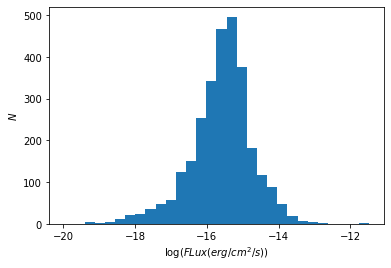

In [41]:
d_MWB = 2.469e+22      ##8 kpc in cm
# r = np.sqrt( d_MWB**2 +  loc_sorted[2]**2 )
# F = np.array(L)/(4*np.pi*r**2)
F = np.array(L)/(4*np.pi*d_MWB**2)

# plt.hist(np.log10(L), 30)
plt.hist(np.log10(F),30)
# plt.xlim(-13, -10)
# plt.ylim(0,10)
plt.xlabel(r"$\log(FLux (erg/cm^2/s) )$")
plt.ylabel(r"$N $")
plt.show()